# CALCULO DE QUINTILES DEL AÑO 2022 AL AÑO 2025 (LM)

### Calculo de Quintiles en Rangos Univariables

In [18]:
# Código Optimizado y Corregido para Clustering RFM
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ================================
# 1. Cargar y preparar datos (optimizado y corregido)
# ================================
def load_and_prepare_data(filepath):
    """Carga y prepara los datos con optimización de memoria y manejo de NaN"""
    # Cargar solo columnas necesarias
    cols = ['Suma de Vta Total', 'Recuento de Fecha', 'Última fecha: Fecha']
    df = pd.read_csv(filepath, encoding='latin1', usecols=cols)
    
    # Convertir tipos de datos para ahorrar memoria
    df['Suma de Vta Total'] = pd.to_numeric(df['Suma de Vta Total'], errors='coerce').astype('float32')
    df['Recuento de Fecha'] = pd.to_numeric(df['Recuento de Fecha'], errors='coerce').astype('float32')
    df['Última fecha: Fecha'] = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce', format='%Y-%m-%d')
    
    # Calcular frescura en días con manejo de NaN
    fecha_base =  df['Última fecha: Fecha'].max()
    df['Frescura (días)'] = (fecha_base - df['Última fecha: Fecha']).dt.days
    
    # Filtrar datos válidos (eliminar NaN antes de convertir a int)
    df = df[
        (df['Suma de Vta Total'] > 0) & 
        (df['Recuento de Fecha'] > 0) & 
        (df['Frescura (días)'].notna()) &  # Añadido para manejar NaN
        (df['Frescura (días)'] > 0)
    ].copy()
    
    # Ahora podemos convertir a int de manera segura
    df['Frescura (días)'] = df['Frescura (días)'].astype('int16')
    
    # Eliminar outliers (percentil 99)
    for col in ['Suma de Vta Total', 'Recuento de Fecha']:
        q99 = df[col].quantile(0.99)
        df = df[df[col] <= q99]
    
    df = df[df['Frescura (días)'] <= 366]
    
    return df

# ================================
# 2. Función de clustering optimizada
# ================================
def optimized_cluster(series, method='minibatch', n_clusters=5, random_state=42):
    """
    Clustering optimizado con:
    - Escalado de datos
    - Elección de método
    - Manejo eficiente de memoria
    """
    # Validar y preparar datos
    valid_values = series.dropna().values.reshape(-1, 1)
    if len(valid_values) == 0:
        return None
    
    # Escalar datos
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(valid_values)
    
    # Seleccionar modelo
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    elif method == 'minibatch':
        model = MiniBatchKMeans(
            n_clusters=n_clusters, 
            random_state=random_state, 
            batch_size=1024,
            n_init=5
        )
    elif method == 'birch':
        model = Birch(n_clusters=n_clusters, threshold=0.5)
    else:
        raise ValueError("Método no válido. Usar 'kmeans', 'minibatch' o 'birch'.")
    
    # Entrenar modelo
    clusters = model.fit_predict(scaled_values)
    
    # Crear DataFrame con resultados
    temp_df = pd.DataFrame({
        'value': valid_values.flatten(),
        'cluster': clusters
    })
    
    # Calcular rangos
    ranges = temp_df.groupby('cluster')['value'].agg(['min', 'max']).reset_index()
    ranges = ranges.sort_values('min').reset_index(drop=True)
    ranges['label'] = [f'R{i}' for i in range(len(ranges))]
    
    return ranges

# ================================
# 3. Función para generar rangos
# ================================
def obtener_rangos(rangos_df, start_from_zero=False):
    """Genera tuplas de rangos desde el formato de clusters"""
    tuplas = []
    rangos_df = rangos_df.sort_values('min').reset_index(drop=True)
    
    for idx, row in rangos_df.iterrows():
        if idx == len(rangos_df) - 1:
            break  # Ignorar el último rango
        
        if idx == 0:
            minimo = 0 if start_from_zero else 1
        else:
            minimo = int(rangos_df.loc[idx - 1, 'max']) + 1
        
        tuplas.append((minimo, int(row['max'])))
    
    return tuplas

# ================================
# 4. Procesamiento principal
# ================================
def main(file_path):
    # Cargar datos
    print("Cargando y preparando datos...")
    df = load_and_prepare_data(file_path)
    
    # Columnas a clusterizar
    columns_to_cluster = {
        'Suma de Vta Total': False,
        'Recuento de Fecha': False,
        'Frescura (días)': True
    }
    
    # Métodos a aplicar
    methods = ['kmeans', 'minibatch', 'birch']
    results = {}
    
    print("\nProcesando clustering...")
    for col, start_zero in columns_to_cluster.items():
        results[col] = {}
        for method in tqdm(methods, desc=f"Clusterizando {col}"):
            ranges = optimized_cluster(df[col], method=method)
            if ranges is not None:
                results[col][method] = obtener_rangos(ranges, start_from_zero=start_zero)
    
    # Mostrar resultados
    print("\n=== Resultados Finales ===")
    for col in columns_to_cluster:
        print(f"\n● Variable: {col}")
        for method in methods:
            if method in results[col]:
                print(f"\nMétodo: {method.upper()}")
                print(results[col][method])
    
    return results

# ================================
# 5. Ejecución
# ================================
if __name__ == "__main__":
    # Cambia esta ruta por tu archivo real
    file_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Clientes-2año-Tienda-2año.csv"
    
    # Ejecutar proceso principal
    resultados = main(file_path)

Cargando y preparando datos...

Procesando clustering...


Clusterizando Frescura (días):  67%|██████▋   | 2/3 [00:00<00:00,  4.90it/s]c:\Users\jose.valdez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (4) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
Clusterizando Frescura (días): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


=== Resultados Finales ===

● Variable: Suma de Vta Total

Método: KMEANS
[(1, 17785), (17786, 37240), (37241, 62060), (62061, 97566)]

Método: MINIBATCH
[(1, 16881), (16882, 37289), (37290, 64592), (64593, 99986)]

Método: BIRCH
[(1, 25200), (25201, 52202), (52203, 82438), (82439, 116450)]

● Variable: Recuento de Fecha

Método: KMEANS
[(1, 4), (5, 9), (10, 16), (17, 28)]

Método: MINIBATCH
[(1, 5), (6, 11), (12, 21), (22, 33)]

Método: BIRCH
[(1, 8), (9, 16), (17, 26), (27, 36)]

● Variable: Frescura (días)

Método: KMEANS
[(0, 38), (39, 93), (94, 165), (166, 255)]

Método: MINIBATCH
[(0, 35), (36, 86), (87, 158), (159, 251)]

Método: BIRCH
[(0, 78), (79, 167), (168, 262)]


### Funciones para Calcular Quintiles de 34 y 36 meses Respectivamente

In [1]:
import pandas as pd
import numpy as np

custom_ranges_value = [(1, 15000), (15001, 30000), (30001,60000),(60001,90000)]  # Rango de 1-7000 y 7001-14000
custom_ranges_freq = [(1, 7), (8, 22),(23, 29),(30,37)]  # Ejemplo para frecuencia (ajústalo según sea necesario)
custom_ranges_freshness = [(0, 90),(91,180),(181,270),(271,365)]  # Frescura con un rango personalizado


def process_data1(custom_ranges_value, custom_ranges_freq, custom_ranges_freshness):
        # Cargar el archivo CSV
        file_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Clientes-34meses-Tienda-34meses.csv"
        df = pd.read_csv(file_path, encoding='latin1')  # Prueba con 'latin1' o 'ISO-8859-1'
        # Asignar nulo a 'Recuento de Fecha' donde 'Suma de Vta Total' es nulo
        #df.loc[df['Suma de Vta Total'].isna(), 'Recuento de Fecha'] = 0
        #df['Suma de Vta Total'] = df['Suma de Vta Total'].fillna(0)

        # Asegurarse de que las columnas están en el formato correcto
        df['Suma de Vta Total'] = pd.to_numeric(df['Suma de Vta Total'], errors='coerce')
        df['Recuento de Fecha'] = pd.to_numeric(df['Recuento de Fecha'], errors='coerce')

        # Contar cuántos valores tienen '-'
        count_missing_freshness = df[df['Última fecha: Fecha'] == '-'].shape[0]

        # Convertir las columnas de fecha a datetime, manejar errores y especificar formato si es conocido
        df['Última fecha: Fecha'] = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce', format='%Y-%m-%d')  # Ajusta el formato según sea necesario


        # Calcular los días de frescura como la diferencia entre la fecha actual y la última fecha de compra
        fecha_actual = pd.Timestamp.now()  # Obtener la fecha actual
        fecha_especifica = df['Última fecha: Fecha'].max()  # Año-Mes-Día
        df['Frescura (días)'] = (fecha_especifica - df['Última fecha: Fecha']).dt.days

        # Eliminar valores negativos en la frescura (pueden ser errores en los datos)
        #df = df[df['Frescura (días)'] >= 0]

        # Función para calcular rangos de igual anchura con exclusión de valores repetidos

        # Modificar función para ajustar el primer intervalo
        def calculate_equal_width_ranges(series, num_bins, use_custom_round=False, start_at_one=False):
            series = series.dropna()  # Eliminar valores NaN
            min_val = series.min()
            max_val = series.max()
            bin_width = (max_val - min_val) / num_bins
            
            if start_at_one:
                intervals = [(1, 1 + bin_width - 1)]
                intervals += [(1 + i * bin_width, 1 + (i + 1) * bin_width - 1) for i in range(1, num_bins)]
            else:
                intervals = [(min_val + i * bin_width, min_val + (i + 1) * bin_width - 1) for i in range(num_bins)]
            
            intervals[-1] = (intervals[-1][0], max_val)  # Ajustar el último intervalo para incluir el valor máximo
            def custom_round(x):
                if x - int(x) >= 0.5:
                    return int(np.ceil(x))
                else:
                    return int(np.floor(x))
            if use_custom_round:
                rounded_intervals = [(custom_round(start), custom_round(end)) for start, end in intervals]
            else:
                rounded_intervals = [(round(start, 2), round(end, 2)) for start, end in intervals]
            
            return min_val, max_val, rounded_intervals



        # Modificar función para permitir múltiples rangos customizados
        def calculate_custom_ranges(series, custom_ranges, num_bins, use_custom_round=False):
            series = series.dropna()
            
            all_custom_ranges = []
            for custom_start, custom_end in custom_ranges:
                custom_range = [(custom_start, custom_end)]
                all_custom_ranges += custom_range
            
            # Asumiendo que calculate_equal_width_ranges retorna min_val, max_val, y ranges
            remaining_series = series[series > custom_ranges[-1][1]]
            remaining_min, remaining_max, remaining_ranges = calculate_equal_width_ranges(remaining_series, num_bins - len(custom_ranges), use_custom_round)
            
            # Combinar los rangos personalizados con los rangos calculados
            all_ranges = all_custom_ranges + remaining_ranges

            # Devolver min, max y todos los rangos (custom_start será el mínimo y remaining_max el máximo)
            return custom_ranges[0][0], remaining_max, all_ranges

        # Definir los rangos personalizados que quieres
        


        # El resto del código sigue igual, contando en intervalos, asignando etiquetas, y guardando los resultados.


        # Número de intervalos que quieres crear
        num_bins = 5

        # Calcular rangos para cada columna relevante
        value_min, value_max, value_ranges = calculate_equal_width_ranges(df['Suma de Vta Total'], num_bins, use_custom_round=False, start_at_one=True)
        freq_min, freq_max, freq_ranges = calculate_equal_width_ranges(df['Recuento de Fecha'], num_bins, use_custom_round=True, start_at_one=True)
        freshness_min, freshness_max, freshness_ranges = calculate_equal_width_ranges(df['Frescura (días)'], num_bins, use_custom_round=True)
        # Calcular rangos personalizados para 'Suma de Vta Total'
        value_min, value_max, value_ranges = calculate_custom_ranges(df['Suma de Vta Total'], custom_ranges_value, num_bins, use_custom_round=True)

        # También podrías modificar 'Recuento de Fecha' o 'Frescura (días)' si es necesario
        freq_min, freq_max, freq_ranges = calculate_custom_ranges(df['Recuento de Fecha'], custom_ranges_freq, num_bins, use_custom_round=True)
        freshness_min, freshness_max, freshness_ranges = calculate_custom_ranges(df['Frescura (días)'], custom_ranges_freshness, num_bins, use_custom_round=True)
        
        # Función para contar las cuentas dentro de cada intervalo
        def count_in_intervals(series, intervals):
            counts = []
            for start, end in intervals:
                count = series[(series >= start) & (series <= end)].count()
                counts.append(count)
            return counts

        # Agregar intervalo extra que cubra desde 0 hasta el inicio del primer intervalo
        def add_zero_interval(ranges):
            # Añadir intervalo 0 - 0 antes del primer intervalo
            intervals = [(0, 0)] + ranges
            return intervals

        # Agregar el intervalo extra para cada conjunto de rangos
        value_ranges_with_zero = add_zero_interval(value_ranges)
        freq_ranges_with_zero = add_zero_interval(freq_ranges)
        freshness_ranges_with_zero = add_zero_interval(freshness_ranges)

        # Filtrar el rango de frescura para eliminar (0, 0)
        #freshness_ranges_with_zero = [interval for interval in freshness_ranges_with_zero if interval != (0, 0)]

        # Contar el número de cuentas en cada intervalo
        value_counts = count_in_intervals(df['Suma de Vta Total'], value_ranges_with_zero)
        freq_counts = count_in_intervals(df['Recuento de Fecha'], freq_ranges_with_zero)
        freshness_counts = count_in_intervals(df['Frescura (días)'], freshness_ranges_with_zero)

        # Crear DataFrames para mostrar los resultados con los conteos
        value_df = pd.DataFrame({
            'Intervalo': [f'{value_ranges_with_zero[i][0]} - {value_ranges_with_zero[i][1]}' for i in range(len(value_ranges_with_zero))],
            'Mínimo': [value_ranges_with_zero[i][0] for i in range(len(value_ranges_with_zero))],
            'Máximo': [value_ranges_with_zero[i][1] for i in range(len(value_ranges_with_zero))],
            'Cuentas': value_counts
        })

        freq_df = pd.DataFrame({
            'Intervalo': [f'{freq_ranges_with_zero[i][0]} - {freq_ranges_with_zero[i][1]}' for i in range(len(freq_ranges_with_zero))],
            'Mínimo': [freq_ranges_with_zero[i][0] for i in range(len(freq_ranges_with_zero))],
            'Máximo': [freq_ranges_with_zero[i][1] for i in range(len(freq_ranges_with_zero))],
            'Cuentas': freq_counts
        })

        freshness_df = pd.DataFrame({
            'Intervalo': [f'{freshness_ranges_with_zero[i][0]} - {freshness_ranges_with_zero[i][1]}' for i in range(len(freshness_ranges_with_zero))],
            'Mínimo': [freshness_ranges_with_zero[i][0] for i in range(len(freshness_ranges_with_zero))],
            'Máximo': [freshness_ranges_with_zero[i][1] for i in range(len(freshness_ranges_with_zero))],
            'Cuentas': freshness_counts
        })



        # Convertir las columnas 'Mínimo' y 'Máximo' a tipo string
        freshness_df['Mínimo'] = freshness_df['Mínimo'].astype(str)
        freshness_df['Máximo'] = freshness_df['Máximo'].astype(str)
        freshness_df['Intervalo'] = freshness_df['Intervalo'].astype(str)
        freshness_df['Cuentas'] = freshness_df['Cuentas'].astype(str)

        # Modificar el DataFrame 'freshness_df' para actualizar la primera fila
        freshness_df.at[0, 'Intervalo'] = '-'
        freshness_df.at[0, 'Mínimo'] = '-'
        freshness_df.at[0, 'Máximo'] = '-'
        freshness_df.at[0, 'Cuentas'] =  count_missing_freshness


        # Convertir la columna 'Cuentas' a tipo numérico, forzando errores a NaN y luego eliminándolos
        value_df['Cuentas'] = pd.to_numeric(value_df['Cuentas'], errors='coerce')
        freq_df['Cuentas'] = pd.to_numeric(freq_df['Cuentas'], errors='coerce')
        freshness_df['Cuentas'] = pd.to_numeric(freshness_df['Cuentas'], errors='coerce')

        # Calcular y agregar la columna de porcentajes para cada DataFrame
        value_df['Total Cuentas'] = value_df['Cuentas'].sum()
        value_df['Porcentaje'] = (value_df['Cuentas'] / value_df['Total Cuentas']) * 100
        value_df['Porcentaje'] = value_df['Porcentaje'].round(2)  # Redondear a 1 decimal
        value_df.drop('Total Cuentas', axis=1, inplace=True)

        freq_df['Total Cuentas'] = freq_df['Cuentas'].sum()
        freq_df['Porcentaje'] = (freq_df['Cuentas'] / freq_df['Total Cuentas']) * 100
        freq_df['Porcentaje'] = freq_df['Porcentaje'].round(2)  # Redondear a 1 decimal
        freq_df.drop('Total Cuentas', axis=1, inplace=True)

        freshness_df['Total Cuentas'] = freshness_df['Cuentas'].sum()
        freshness_df['Porcentaje'] = (freshness_df['Cuentas'] / freshness_df['Total Cuentas']) * 100
        freshness_df['Porcentaje'] = freshness_df['Porcentaje'].round(2)  # Redondear a 1 decimal
        freshness_df.drop('Total Cuentas', axis=1, inplace=True)
        freshness_df = freshness_df.iloc[::-1].reset_index(drop=True)
        freshness_df.index = range(len(freshness_df)-1, -1, -1)
        # Ordenar los DataFrames por la columna 'Máximo' en orden descendente

        value_df_sorted_max = value_df.sort_values(by='Máximo', ascending=False)
        freq_df_sorted_max = freq_df.sort_values(by='Máximo', ascending=False)



        # Mostrar resultados ordenados por 'Máximo'
        print("Rangos del Valor de Compra:")
        print(value_df_sorted_max)
        total_cuentas = value_df['Cuentas'].sum()
        print(f"El total de cuentas es: {total_cuentas}")
        print("\nRangos de la Frecuencia de Visita:")
        print(freq_df_sorted_max)
        total_cuentas = freq_df['Cuentas'].sum()
        print(f"El total de cuentas es: {total_cuentas}")
        print("\nRangos de la Frescura:")
        print(freshness_df)
        total_cuentas = freshness_df['Cuentas'].sum()
        print(f"El total de cuentas es: {total_cuentas}")
        df.fillna({'Frescura (días)': '-'}, inplace=True)
        def replace_zero_range(ranges):
            # Reemplaza el rango (0, 0) por ("-", "-")
            return [("-", "-") if r == (0, 0) else r for r in ranges]

        # Llamar a la función para hacer el reemplazo
        freshness_ranges_with_zero = replace_zero_range(freshness_ranges_with_zero)

        # Define tu función classify_data
        def classify_data(value, ranges, labels):
            # Manejar el caso donde el valor es "-"
            if value == "-":
                return "R0"  # Clasificación especial para guiones

            # Intentar convertir el valor a float
            try:
                value = float(value)
            except ValueError:
                return None  # O un valor por defecto si la conversión falla

            # Clasificación según los rangos
            for (start, end), label in zip(ranges, labels):
                # Comprobar que start y end son números
                if start != "-" and end != "-":
                    if start <= value <= end:
                        return label

            return None  # O un valor por defecto si no se encuentra en ningún rango
        # Asignar etiquetas a los intervalos
        value_labels = [f'V{i}' for i in range(len(value_ranges_with_zero))]
        freq_labels = [f'F{i}' for i in range(len(freq_ranges_with_zero))]
        #freshness_labels = [f'R{i}' for i in range(len(freshness_ranges_with_zero))]
        freshness_labels = ['R0', 'R5', 'R4', 'R3', 'R2', 'R1']
        # Clasificar los datos y asignar etiquetas
        df['ETIQ1'] = df['Suma de Vta Total'].apply(lambda x: classify_data(x, value_ranges_with_zero, value_labels))
        df['ETIQ2'] = df['Recuento de Fecha'].apply(lambda x: classify_data(x, freq_ranges_with_zero, freq_labels))
        df['ETIQ3'] = df['Frescura (días)'].apply(lambda x: classify_data(x, freshness_ranges_with_zero, freshness_labels))
        #print(freshness_ranges_with_zero)
        #print(freshness_labels)
        # Guardar los resultados en un archivo CSV con las columnas CUENTA, ETIQ1, ETIQ2, ETIQ3
        output_file_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes34meses.csv"
        df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

#process_data(custom_ranges_value, custom_ranges_freq, custom_ranges_freshness)

In [2]:
import pandas as pd
import numpy as np

custom_ranges_value = [(1, 15000), (15001, 30000), (30001,60000),(60001,90000)]  # Rango de 1-7000 y 7001-14000
custom_ranges_freq = [(1, 7), (8, 22),(23, 29),(30,37)]  # Ejemplo para frecuencia (ajústalo según sea necesario)
custom_ranges_freshness = [(0, 90),(91,180),(181,270),(271,365)]  # Frescura con un rango personalizado


def process_data2(custom_ranges_value, custom_ranges_freq, custom_ranges_freshness):
        # Cargar el archivo CSV
        file_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Clientes-2año-Tienda-2año.csv"
        df = pd.read_csv(file_path, encoding='latin1')  # Prueba con 'latin1' o 'ISO-8859-1'
        # Asignar nulo a 'Recuento de Fecha' donde 'Suma de Vta Total' es nulo
        #df.loc[df['Suma de Vta Total'].isna(), 'Recuento de Fecha'] = 0
        #df['Suma de Vta Total'] = df['Suma de Vta Total'].fillna(0)

        # Asegurarse de que las columnas están en el formato correcto
        df['Suma de Vta Total'] = pd.to_numeric(df['Suma de Vta Total'], errors='coerce')
        df['Recuento de Fecha'] = pd.to_numeric(df['Recuento de Fecha'], errors='coerce')

        # Contar cuántos valores tienen '-'
        count_missing_freshness = df[df['Última fecha: Fecha'] == '-'].shape[0]

        # Convertir las columnas de fecha a datetime, manejar errores y especificar formato si es conocido
        df['Última fecha: Fecha'] = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce', format='%Y-%m-%d')  # Ajusta el formato según sea necesario


        # Calcular los días de frescura como la diferencia entre la fecha actual y la última fecha de compra
        fecha_actual = pd.Timestamp.now()  # Obtener la fecha actual
        fecha_especifica = df['Última fecha: Fecha'].max()  # Año-Mes-Día
        df['Frescura (días)'] = (fecha_especifica - df['Última fecha: Fecha']).dt.days

        # Eliminar valores negativos en la frescura (pueden ser errores en los datos)
        #df = df[df['Frescura (días)'] >= 0]

        # Función para calcular rangos de igual anchura con exclusión de valores repetidos

        # Modificar función para ajustar el primer intervalo
        def calculate_equal_width_ranges(series, num_bins, use_custom_round=False, start_at_one=False):
            series = series.dropna()  # Eliminar valores NaN
            min_val = series.min()
            max_val = series.max()
            bin_width = (max_val - min_val) / num_bins
            
            if start_at_one:
                intervals = [(1, 1 + bin_width - 1)]
                intervals += [(1 + i * bin_width, 1 + (i + 1) * bin_width - 1) for i in range(1, num_bins)]
            else:
                intervals = [(min_val + i * bin_width, min_val + (i + 1) * bin_width - 1) for i in range(num_bins)]
            
            intervals[-1] = (intervals[-1][0], max_val)  # Ajustar el último intervalo para incluir el valor máximo
            def custom_round(x):
                if x - int(x) >= 0.5:
                    return int(np.ceil(x))
                else:
                    return int(np.floor(x))
            if use_custom_round:
                rounded_intervals = [(custom_round(start), custom_round(end)) for start, end in intervals]
            else:
                rounded_intervals = [(round(start, 2), round(end, 2)) for start, end in intervals]
            
            return min_val, max_val, rounded_intervals



        # Modificar función para permitir múltiples rangos customizados
        def calculate_custom_ranges(series, custom_ranges, num_bins, use_custom_round=False):
            series = series.dropna()
            
            all_custom_ranges = []
            for custom_start, custom_end in custom_ranges:
                custom_range = [(custom_start, custom_end)]
                all_custom_ranges += custom_range
            
            # Asumiendo que calculate_equal_width_ranges retorna min_val, max_val, y ranges
            remaining_series = series[series > custom_ranges[-1][1]]
            remaining_min, remaining_max, remaining_ranges = calculate_equal_width_ranges(remaining_series, num_bins - len(custom_ranges), use_custom_round)
            
            # Combinar los rangos personalizados con los rangos calculados
            all_ranges = all_custom_ranges + remaining_ranges

            # Devolver min, max y todos los rangos (custom_start será el mínimo y remaining_max el máximo)
            return custom_ranges[0][0], remaining_max, all_ranges

        # Definir los rangos personalizados que quieres
        


        # El resto del código sigue igual, contando en intervalos, asignando etiquetas, y guardando los resultados.


        # Número de intervalos que quieres crear
        num_bins = 5

        # Calcular rangos para cada columna relevante
        value_min, value_max, value_ranges = calculate_equal_width_ranges(df['Suma de Vta Total'], num_bins, use_custom_round=False, start_at_one=True)
        freq_min, freq_max, freq_ranges = calculate_equal_width_ranges(df['Recuento de Fecha'], num_bins, use_custom_round=True, start_at_one=True)
        freshness_min, freshness_max, freshness_ranges = calculate_equal_width_ranges(df['Frescura (días)'], num_bins, use_custom_round=True)
        # Calcular rangos personalizados para 'Suma de Vta Total'
        value_min, value_max, value_ranges = calculate_custom_ranges(df['Suma de Vta Total'], custom_ranges_value, num_bins, use_custom_round=True)

        # También podrías modificar 'Recuento de Fecha' o 'Frescura (días)' si es necesario
        freq_min, freq_max, freq_ranges = calculate_custom_ranges(df['Recuento de Fecha'], custom_ranges_freq, num_bins, use_custom_round=True)
        freshness_min, freshness_max, freshness_ranges = calculate_custom_ranges(df['Frescura (días)'], custom_ranges_freshness, num_bins, use_custom_round=True)
        
        # Función para contar las cuentas dentro de cada intervalo
        def count_in_intervals(series, intervals):
            counts = []
            for start, end in intervals:
                count = series[(series >= start) & (series <= end)].count()
                counts.append(count)
            return counts

        # Agregar intervalo extra que cubra desde 0 hasta el inicio del primer intervalo
        def add_zero_interval(ranges):
            # Añadir intervalo 0 - 0 antes del primer intervalo
            intervals = [(0, 0)] + ranges
            return intervals

        # Agregar el intervalo extra para cada conjunto de rangos
        value_ranges_with_zero = add_zero_interval(value_ranges)
        freq_ranges_with_zero = add_zero_interval(freq_ranges)
        freshness_ranges_with_zero = add_zero_interval(freshness_ranges)

        # Filtrar el rango de frescura para eliminar (0, 0)
        #freshness_ranges_with_zero = [interval for interval in freshness_ranges_with_zero if interval != (0, 0)]

        # Contar el número de cuentas en cada intervalo
        value_counts = count_in_intervals(df['Suma de Vta Total'], value_ranges_with_zero)
        freq_counts = count_in_intervals(df['Recuento de Fecha'], freq_ranges_with_zero)
        freshness_counts = count_in_intervals(df['Frescura (días)'], freshness_ranges_with_zero)

        # Crear DataFrames para mostrar los resultados con los conteos
        value_df = pd.DataFrame({
            'Intervalo': [f'{value_ranges_with_zero[i][0]} - {value_ranges_with_zero[i][1]}' for i in range(len(value_ranges_with_zero))],
            'Mínimo': [value_ranges_with_zero[i][0] for i in range(len(value_ranges_with_zero))],
            'Máximo': [value_ranges_with_zero[i][1] for i in range(len(value_ranges_with_zero))],
            'Cuentas': value_counts
        })

        freq_df = pd.DataFrame({
            'Intervalo': [f'{freq_ranges_with_zero[i][0]} - {freq_ranges_with_zero[i][1]}' for i in range(len(freq_ranges_with_zero))],
            'Mínimo': [freq_ranges_with_zero[i][0] for i in range(len(freq_ranges_with_zero))],
            'Máximo': [freq_ranges_with_zero[i][1] for i in range(len(freq_ranges_with_zero))],
            'Cuentas': freq_counts
        })

        freshness_df = pd.DataFrame({
            'Intervalo': [f'{freshness_ranges_with_zero[i][0]} - {freshness_ranges_with_zero[i][1]}' for i in range(len(freshness_ranges_with_zero))],
            'Mínimo': [freshness_ranges_with_zero[i][0] for i in range(len(freshness_ranges_with_zero))],
            'Máximo': [freshness_ranges_with_zero[i][1] for i in range(len(freshness_ranges_with_zero))],
            'Cuentas': freshness_counts
        })



        # Convertir las columnas 'Mínimo' y 'Máximo' a tipo string
        freshness_df['Mínimo'] = freshness_df['Mínimo'].astype(str)
        freshness_df['Máximo'] = freshness_df['Máximo'].astype(str)
        freshness_df['Intervalo'] = freshness_df['Intervalo'].astype(str)
        freshness_df['Cuentas'] = freshness_df['Cuentas'].astype(str)

        # Modificar el DataFrame 'freshness_df' para actualizar la primera fila
        freshness_df.at[0, 'Intervalo'] = '-'
        freshness_df.at[0, 'Mínimo'] = '-'
        freshness_df.at[0, 'Máximo'] = '-'
        freshness_df.at[0, 'Cuentas'] =  count_missing_freshness


        # Convertir la columna 'Cuentas' a tipo numérico, forzando errores a NaN y luego eliminándolos
        value_df['Cuentas'] = pd.to_numeric(value_df['Cuentas'], errors='coerce')
        freq_df['Cuentas'] = pd.to_numeric(freq_df['Cuentas'], errors='coerce')
        freshness_df['Cuentas'] = pd.to_numeric(freshness_df['Cuentas'], errors='coerce')

        # Calcular y agregar la columna de porcentajes para cada DataFrame
        value_df['Total Cuentas'] = value_df['Cuentas'].sum()
        value_df['Porcentaje'] = (value_df['Cuentas'] / value_df['Total Cuentas']) * 100
        value_df['Porcentaje'] = value_df['Porcentaje'].round(2)  # Redondear a 1 decimal
        value_df.drop('Total Cuentas', axis=1, inplace=True)

        freq_df['Total Cuentas'] = freq_df['Cuentas'].sum()
        freq_df['Porcentaje'] = (freq_df['Cuentas'] / freq_df['Total Cuentas']) * 100
        freq_df['Porcentaje'] = freq_df['Porcentaje'].round(2)  # Redondear a 1 decimal
        freq_df.drop('Total Cuentas', axis=1, inplace=True)

        freshness_df['Total Cuentas'] = freshness_df['Cuentas'].sum()
        freshness_df['Porcentaje'] = (freshness_df['Cuentas'] / freshness_df['Total Cuentas']) * 100
        freshness_df['Porcentaje'] = freshness_df['Porcentaje'].round(2)  # Redondear a 1 decimal
        freshness_df.drop('Total Cuentas', axis=1, inplace=True)
        freshness_df = freshness_df.iloc[::-1].reset_index(drop=True)
        freshness_df.index = range(len(freshness_df)-1, -1, -1)
        # Ordenar los DataFrames por la columna 'Máximo' en orden descendente

        value_df_sorted_max = value_df.sort_values(by='Máximo', ascending=False)
        freq_df_sorted_max = freq_df.sort_values(by='Máximo', ascending=False)



        # Mostrar resultados ordenados por 'Máximo'
        print("Rangos del Valor de Compra:")
        print(value_df_sorted_max)
        total_cuentas = value_df['Cuentas'].sum()
        print(f"El total de cuentas es: {total_cuentas}")
        print("\nRangos de la Frecuencia de Visita:")
        print(freq_df_sorted_max)
        total_cuentas = freq_df['Cuentas'].sum()
        print(f"El total de cuentas es: {total_cuentas}")
        print("\nRangos de la Frescura:")
        print(freshness_df)
        total_cuentas = freshness_df['Cuentas'].sum()
        print(f"El total de cuentas es: {total_cuentas}")
        df.fillna({'Frescura (días)': '-'}, inplace=True)
        def replace_zero_range(ranges):
            # Reemplaza el rango (0, 0) por ("-", "-")
            return [("-", "-") if r == (0, 0) else r for r in ranges]

        # Llamar a la función para hacer el reemplazo
        freshness_ranges_with_zero = replace_zero_range(freshness_ranges_with_zero)

        # Define tu función classify_data
        def classify_data(value, ranges, labels):
            # Manejar el caso donde el valor es "-"
            if value == "-":
                return "R0"  # Clasificación especial para guiones

            # Intentar convertir el valor a float
            try:
                value = float(value)
            except ValueError:
                return None  # O un valor por defecto si la conversión falla

            # Clasificación según los rangos
            for (start, end), label in zip(ranges, labels):
                # Comprobar que start y end son números
                if start != "-" and end != "-":
                    if start <= value <= end:
                        return label

            return None  # O un valor por defecto si no se encuentra en ningún rango
        # Asignar etiquetas a los intervalos
        value_labels = [f'V{i}' for i in range(len(value_ranges_with_zero))]
        freq_labels = [f'F{i}' for i in range(len(freq_ranges_with_zero))]
        #freshness_labels = [f'R{i}' for i in range(len(freshness_ranges_with_zero))]
        freshness_labels = ['R0', 'R5', 'R4', 'R3', 'R2', 'R1']
        # Clasificar los datos y asignar etiquetas
        df['ETIQ1'] = df['Suma de Vta Total'].apply(lambda x: classify_data(x, value_ranges_with_zero, value_labels))
        df['ETIQ2'] = df['Recuento de Fecha'].apply(lambda x: classify_data(x, freq_ranges_with_zero, freq_labels))
        df['ETIQ3'] = df['Frescura (días)'].apply(lambda x: classify_data(x, freshness_ranges_with_zero, freshness_labels))
        #print(freshness_ranges_with_zero)
        #print(freshness_labels)
        # Guardar los resultados en un archivo CSV con las columnas CUENTA, ETIQ1, ETIQ2, ETIQ3
        output_file_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
        df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

#process_data(custom_ranges_value, custom_ranges_freq, custom_ranges_freshness)

### Obtener Quintiles para Clientes de 34 y 36 meses Respectivamente (Modificar Rangos Si Cambiaron Drasticamente)

In [3]:
custom_ranges_value = [(1, 17000), (17001, 36000), (36001,61000),(61001,96000)]  # Rango de 1-7000 y 7001-14000
custom_ranges_freq = [(1, 6), (7, 13),(14, 21),(22,33)]  # Ejemplo para frecuencia (ajústalo según sea necesario)
custom_ranges_freshness = [(0, 90),(91,150),(151,270),(271,365)]  # Frescura con un rango personalizado


process_data1(custom_ranges_value, custom_ranges_freq, custom_ranges_freshness)
process_data2(custom_ranges_value, custom_ranges_freq, custom_ranges_freshness)

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\1028590280.py:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')  # Prueba con 'latin1' o 'ISO-8859-1'


Rangos del Valor de Compra:
        Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
5  96005 - 866586   96005  866586     4539        3.68
4   61001 - 96000   61001   96000     8292        6.72
3   36001 - 61000   36001   61000    17340       14.06
2   17001 - 36000   17001   36000    30535       24.75
1       1 - 17000       1   17000    52072       42.21
0           0 - 0       0       0    10592        8.59
El total de cuentas es: 123370

Rangos de la Frecuencia de Visita:
  Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
5  34 - 256      34     256     4710        3.82
4   22 - 33      22      33     8807        7.14
3   14 - 21      14      21    15453       12.53
2    7 - 13       7      13    30007       24.32
1     1 - 6       1       6    53802       43.61
0     0 - 0       0       0    10591        8.58
El total de cuentas es: 123370

Rangos de la Frescura:
    Intervalo Mínimo Máximo  Cuentas  Porcentaje
5  366 - 1035    366   1035    17506       14.19
4   271 - 365    271    

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\124296964.py:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')  # Prueba con 'latin1' o 'ISO-8859-1'


Rangos del Valor de Compra:
        Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
5  96001 - 919744   96001  919744     5236        4.20
4   61001 - 96000   61001   96000     9167        7.35
3   36001 - 61000   36001   61000    18461       14.80
2   17001 - 36000   17001   36000    30978       24.83
1       1 - 17000       1   17000    51137       40.98
0           0 - 0       0       0     9796        7.85
El total de cuentas es: 124775

Rangos de la Frecuencia de Visita:
  Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
5  34 - 274      34     274     5475        4.39
4   22 - 33      22      33     9734        7.80
3   14 - 21      14      21    16291       13.06
2    7 - 13       7      13    30302       24.29
1     1 - 6       1       6    53178       42.62
0     0 - 0       0       0     9795        7.85
El total de cuentas es: 124775

Rangos de la Frescura:
    Intervalo Mínimo Máximo  Cuentas  Porcentaje
5  366 - 1094    366   1094    18372       14.72
4   271 - 365    271    

### Clusterización de Clientes con KMeans 

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ================================
# 1. Cargar el archivo CSV
# ================================
file_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Clientes-2año-Tienda-2año.csv"
df = pd.read_csv(file_path, encoding='latin1')

# ================================
# 2. Preparación de datos
# ================================
df['Suma de Vta Total'] = pd.to_numeric(df['Suma de Vta Total'], errors='coerce')
df['Recuento de Fecha'] = pd.to_numeric(df['Recuento de Fecha'], errors='coerce')
df['Última fecha: Fecha'] = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce', format='%Y-%m-%d')

fecha_base = df['Última fecha: Fecha'].max()
df['Frescura (días)'] = (fecha_base - df['Última fecha: Fecha']).dt.days

df = df[(df['Suma de Vta Total'] > 0) & 
        (df['Recuento de Fecha'] > 0) ]

# ================================
# 3. Normalizar las variables
# ================================
scaler = StandardScaler()
variables = ['Suma de Vta Total', 'Recuento de Fecha', 'Frescura (días)']
df_scaled = scaler.fit_transform(df[variables])

# ================================
# 4. Aplicar pesos
# ================================
pesos = np.array([0.5, 0.5, 25.0])  # Ventas, Frecuencia, Frescura
df_scaled_ponderado = df_scaled * pesos

# ================================
# 5. Aplicar clustering multivariado
# ================================
def apply_clustering(data, method='kmeans', n_clusters=3, random_state=42):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    elif method == 'minibatch':
        model = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, batch_size=500, n_init=10)
    elif method == 'birch':
        model = Birch(n_clusters=n_clusters)
    else:
        raise ValueError("Método no válido. Usa 'kmeans', 'minibatch' o 'birch'.")
    
    clusters = model.fit_predict(data)
    return clusters, silhouette_score(data, clusters)

# ================================
# 6. Ejecutar clustering con pesos
# ================================
n_clusters = 4
df['Cluster_KMeans'], score_kmeans = apply_clustering(df_scaled_ponderado, method='kmeans', n_clusters=n_clusters)

# ================================
# 7. Análisis de clústeres
# ================================
cluster_summary = df.groupby('Cluster_KMeans')[variables].mean()
cluster_summary['Score'] = (
    cluster_summary['Suma de Vta Total'] +
    cluster_summary['Recuento de Fecha'] -
    cluster_summary['Frescura (días)']
)
orden_clusters = cluster_summary.sort_values('Score', ascending=False).index.tolist()

# ================================
# 8. Guardar resultados
# ================================
print(f"Silhouette Score - KMeans: {score_kmeans:.4f}")
output_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\Clientes_Clusterizados.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Archivo guardado en: {output_path}")


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\4274901812.py:12: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')


Silhouette Score - KMeans: 0.6653
Archivo guardado en: C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\Clientes_Clusterizados.csv


### Graficar Resultados

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\2617803721.py:9: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file, encoding='utf-8-sig')


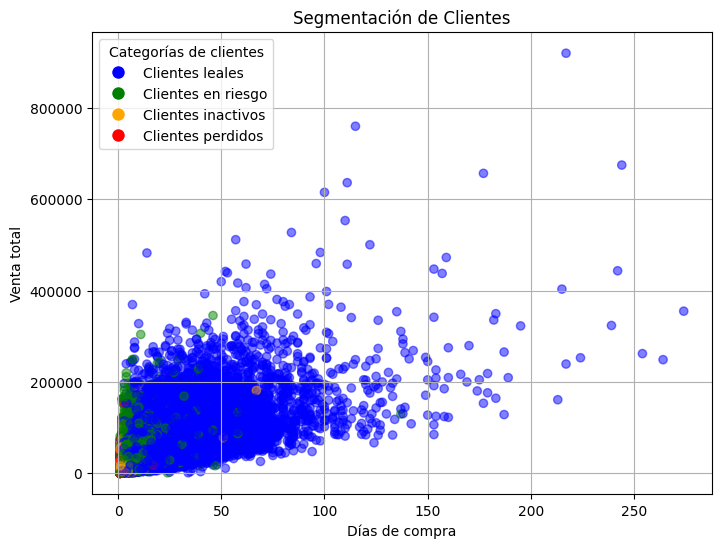

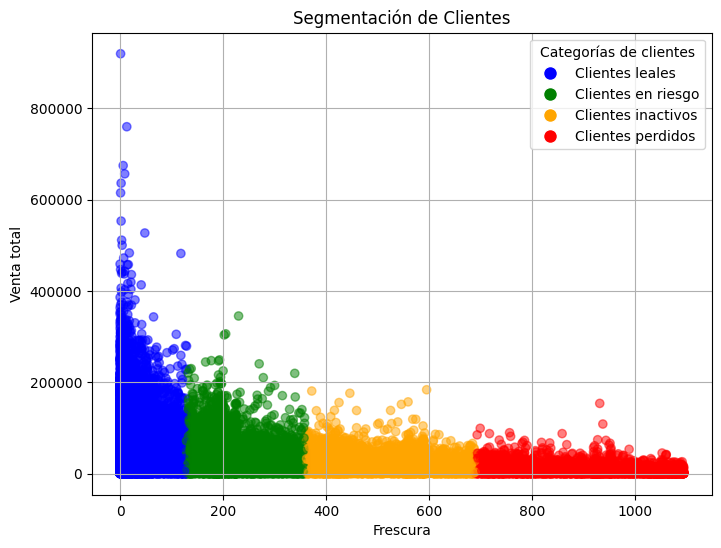

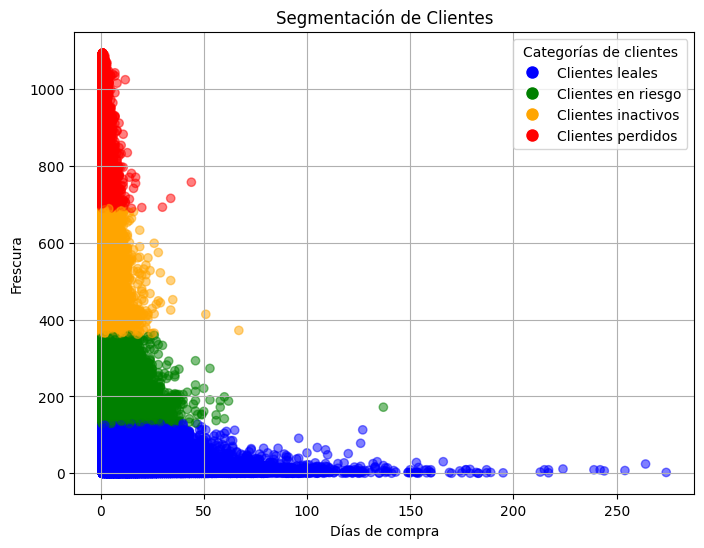

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

output_file = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\Clientes_Clusterizados.csv"
# Leer el archivo CSV
df = pd.read_csv(output_file, encoding='utf-8-sig')
#df = df[(df["Suma de Vta Total"] <= 5) & (df["Recuento de Fecha"] <= 5)]

# Configuración personalizada
# Crear un nuevo diccionario reordenado
nombres = [
    'Clientes leales',
    'Clientes en riesgo',
    'Clientes inactivos',
    'Clientes perdidos'
]

colores = ['blue', 'green','orange' ,'red']

cluster_config = {
    old_label: {'nombre': nombre, 'color': color}
    for old_label, nombre, color in zip(orden_clusters, nombres, colores)
}

# Diccionario para renombrar ejes
axis_labels = {
    'Recuento de Fecha': 'Días de compra',
    'Suma de Vta Total': 'Venta total',
    'Frescura (días)': 'Frescura'
}

# Función para graficar clusters
def plot_clusters(df, x_col, y_col, cluster_col, title):
    plt.figure(figsize=(8, 6))
    
    # Mapear los valores de cluster a colores y nombres
    colors = df[cluster_col].map({k: v['color'] for k, v in cluster_config.items()})
    
    scatter = plt.scatter(df[x_col], df[y_col], c=colors, alpha=0.5)
    
    # Crear leyenda personalizada con los nuevos nombres
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                      label=cluster_config[i]['nombre'], 
                      markerfacecolor=cluster_config[i]['color'], 
                      markersize=10) 
                      for i in cluster_config.keys()]
    
    plt.legend(handles=legend_elements, title='Categorías de clientes')
    
    plt.xlabel(axis_labels.get(x_col, x_col))
    plt.ylabel(axis_labels.get(y_col, y_col))
    plt.title(title)
    plt.grid(True)
    plt.show()

# Graficar diferentes combinaciones
plot_clusters(df, 'Recuento de Fecha', 'Suma de Vta Total', 'Cluster_KMeans', 'Segmentación de Clientes')
plot_clusters(df, 'Frescura (días)', 'Suma de Vta Total', 'Cluster_KMeans', 'Segmentación de Clientes')
plot_clusters(df, 'Recuento de Fecha', 'Frescura (días)', 'Cluster_KMeans', 'Segmentación de Clientes')


### Guardar los resultados en el archivo de la Clusterización en QuintilesClientes2año.csv

In [8]:
import pandas as pd
import os

# Ruta base del archivo
ruta_clusters = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\Clientes_Clusterizados.csv"
ruta_quintiles = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
ruta_salida = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters"


df_clusters = pd.read_csv(ruta_clusters, encoding='utf-8-sig')
df_quintiles = pd.read_csv(ruta_quintiles, encoding='utf-8-sig')

# Eliminar 'Cluster_KMeans' si existe en df_quintiles para evitar duplicados
if 'Cluster_KMeans' in df_quintiles.columns:
    df_quintiles = df_quintiles.drop(columns=['Cluster_KMeans'])

# Unir los dataframes
df_final = df_quintiles.merge(df_clusters[['CUENTA', 'Cluster_KMeans']], on='CUENTA', how='left')

# Crear cluster_summary para definir orden de etiquetas
cluster_summary = df_clusters.groupby('Cluster_KMeans')[['Suma de Vta Total', 'Recuento de Fecha', 'Frescura (días)']].mean()
cluster_summary['Score'] = (
    cluster_summary['Suma de Vta Total'] +
    cluster_summary['Recuento de Fecha'] -
    cluster_summary['Frescura (días)'] 
)
orden_clusters = cluster_summary.sort_values('Score', ascending=False).index.tolist()

# Asignar nombres según el orden
nombres = [
    'Clientes leales',
    'Clientes en riesgo',
    'Clientes inactivos',
    'Clientes perdidos'
]

cluster_label_map = {cluster: nombre for cluster, nombre in zip(orden_clusters, nombres)}

# Asignar etiquetas al dataframe final
df_final['Tipo_Cliente'] = df_final['Cluster_KMeans'].map(cluster_label_map)
df_final['Tipo_Cliente'] = df_final['Tipo_Cliente'].fillna('Dato no disponible')
df_final = df_final.drop_duplicates()
# Guardar el archivo resultante
output_file = os.path.join(ruta_salida, "QuintilesClientes2año.csv")
df_final.to_csv(output_file, index=False, encoding='utf-8-sig')  # Cambiado ruta_salida por output_file

print(f"Archivo guardado en: {output_file}")

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\2163247219.py:10: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clusters = pd.read_csv(ruta_clusters, encoding='utf-8-sig')
C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\2163247219.py:11: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_quintiles = pd.read_csv(ruta_quintiles, encoding='utf-8-sig')


Archivo guardado en: C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv


### Se realiza la SubClusterización para cada Cluster

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\3496697418.py:10: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(ruta_quintiles, encoding='utf-8-sig')
C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\3496697418.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_todos,


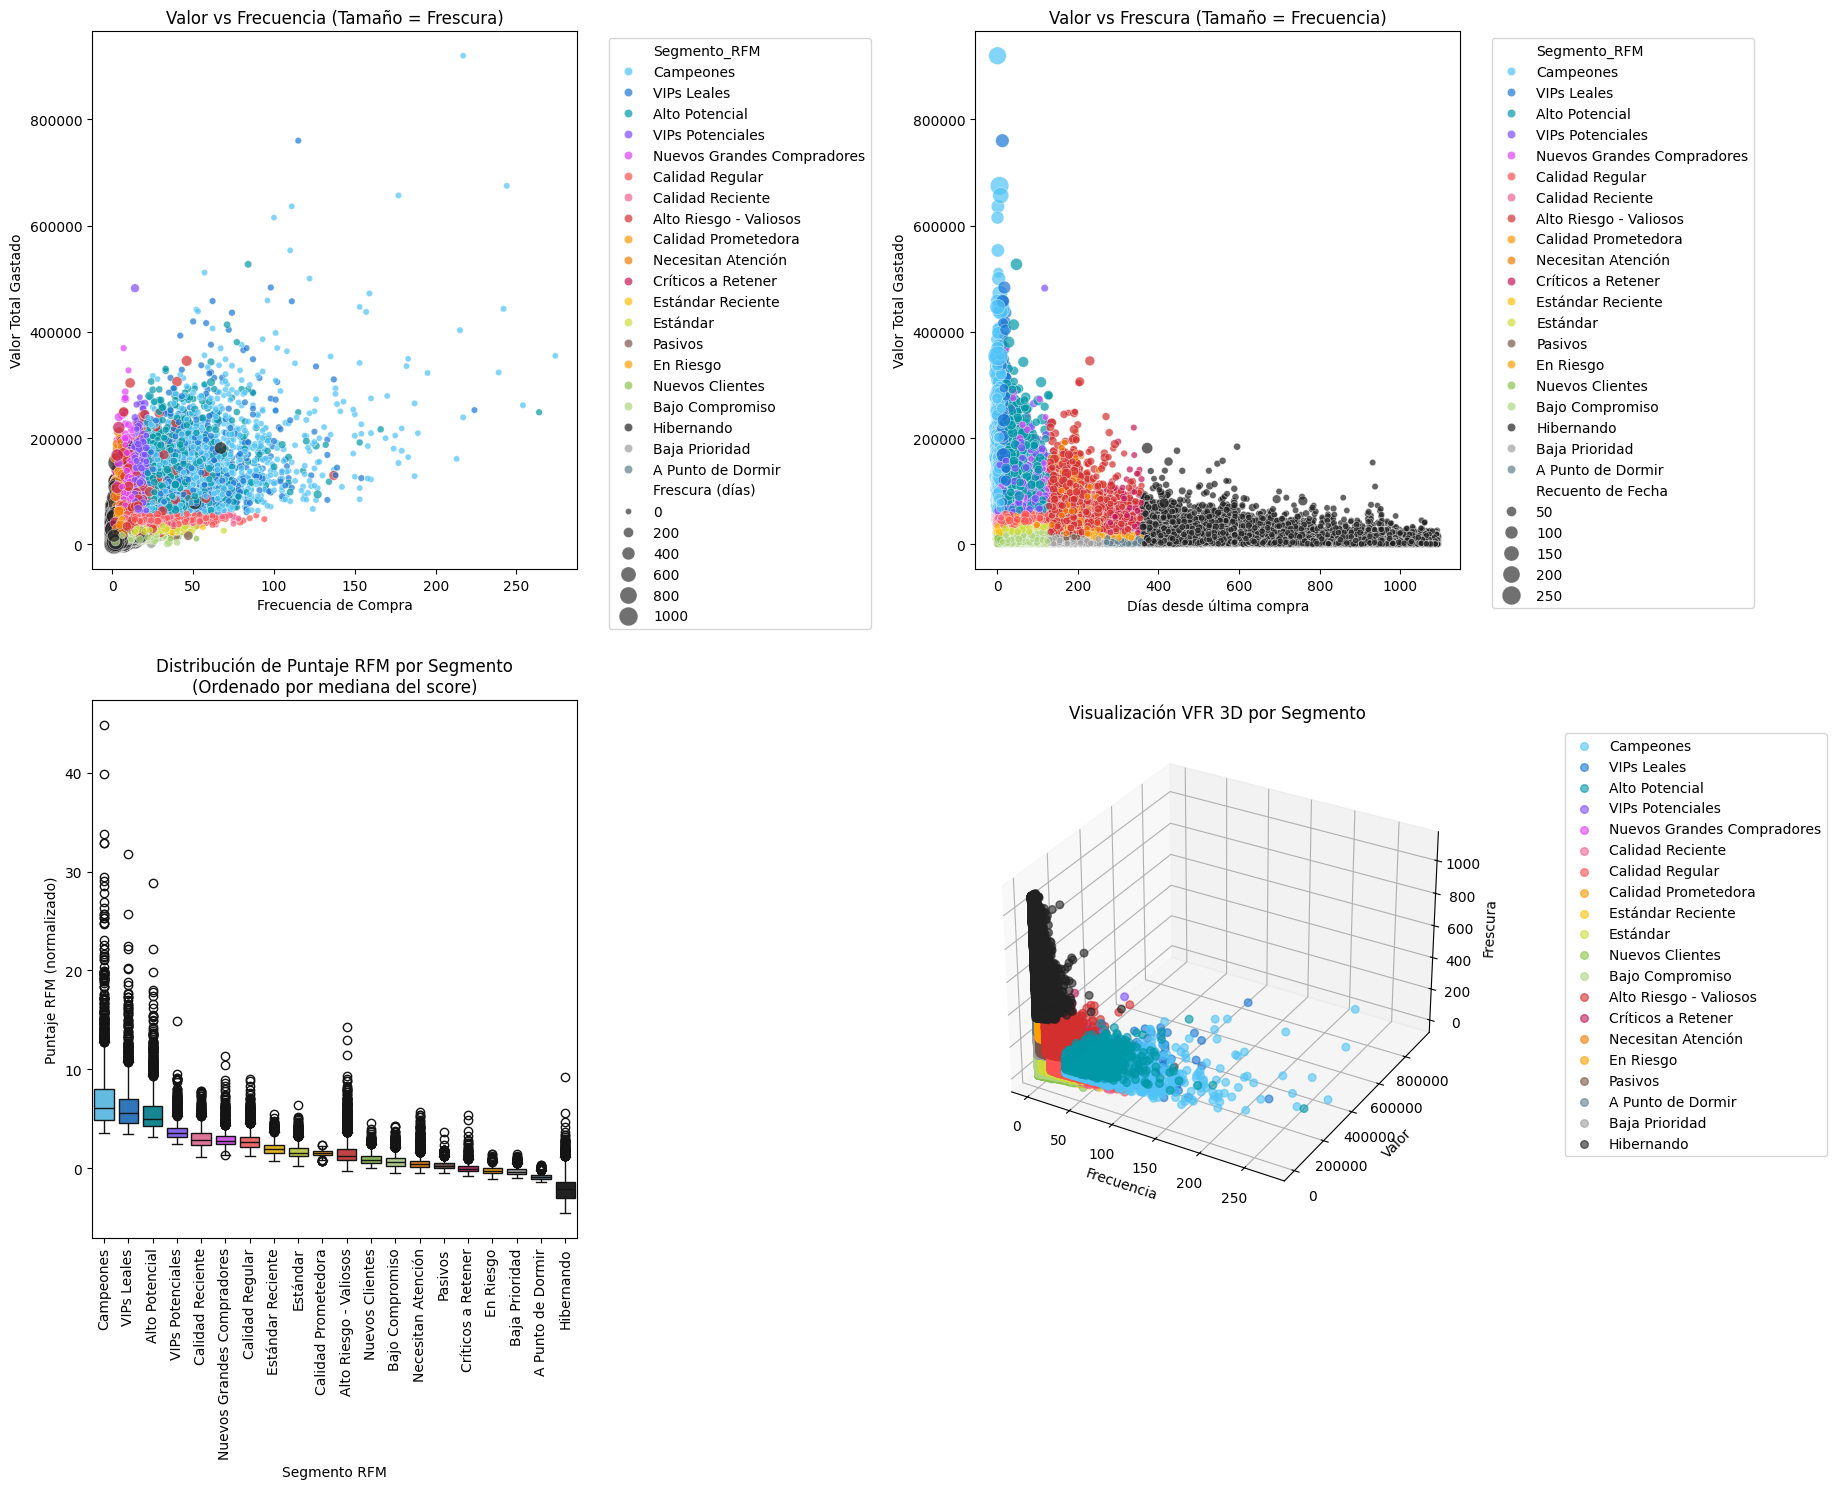

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\3496697418.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data.rename(columns={


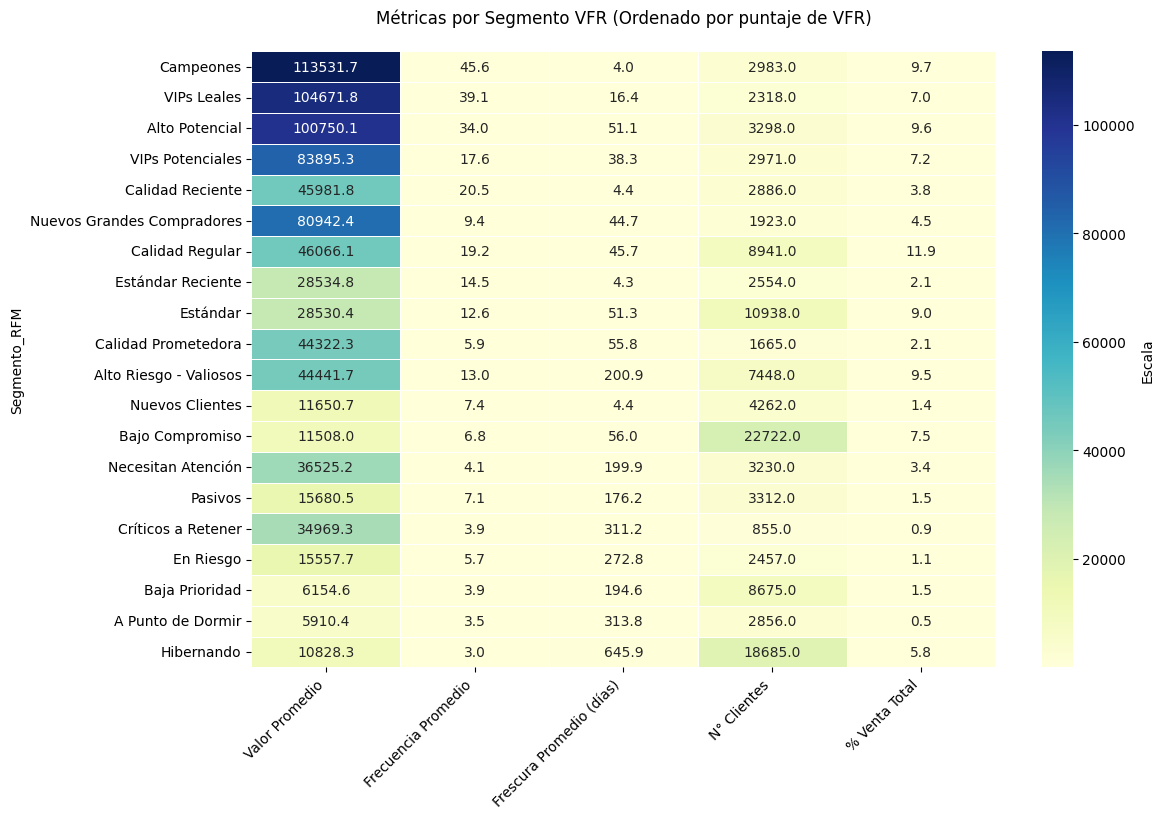

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\3496697418.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index,


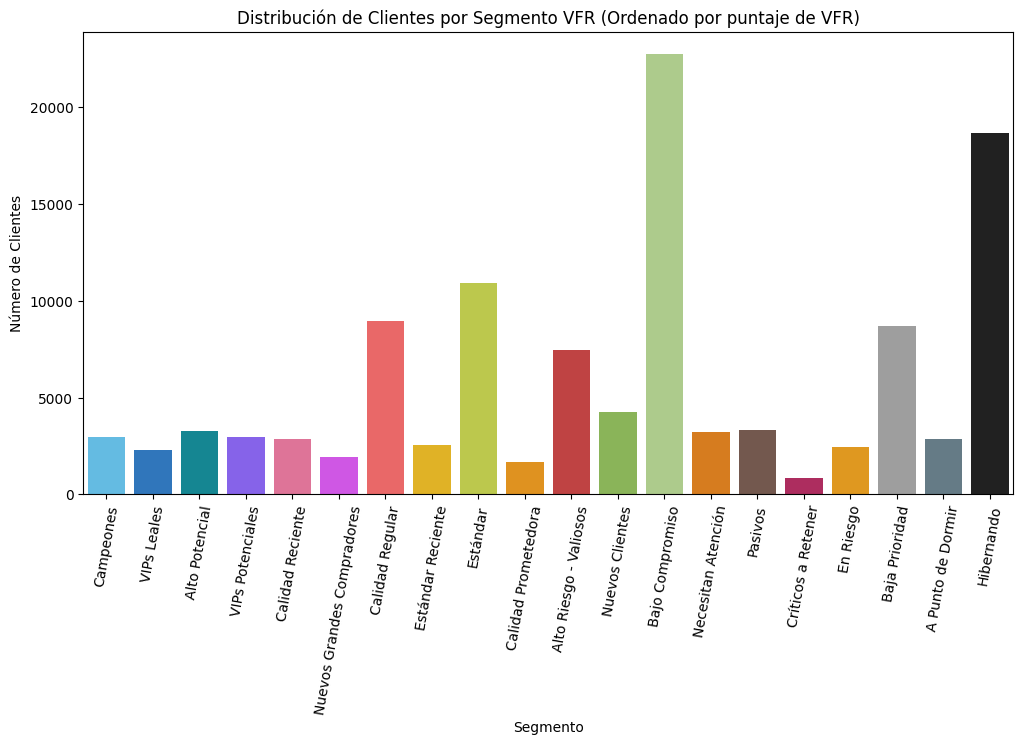

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\3496697418.py:267: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_quintiles = pd.read_csv(ruta_quintiles)


Archivo actualizado guardado en: C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import os

ruta_quintiles = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
df_final = pd.read_csv(ruta_quintiles, encoding='utf-8-sig')
# 1. Filtrar todos los clusters de interés (incluyendo inactivos y perdidos)
df_todos = df_final[df_final['Tipo_Cliente'].isin(['Clientes leales', 'Clientes en riesgo', 'Clientes inactivos', 'Clientes perdidos'])].copy()
df_todos['Frescura (días)'] = pd.to_numeric(df_todos['Frescura (días)'], errors='coerce')

# 2. Calcular quintiles para segmentación - SEPARADO POR TIPO DE CLIENTE
variables = ['Suma de Vta Total', 'Recuento de Fecha', 'Frescura (días)']
percentiles = [20, 40, 60, 80]  # Quintiles para mayor granularidad

# Calcular percentiles para cada variable y cada tipo de cliente
vfr_percentiles = {
    'Clientes leales': {},
    'Clientes en riesgo': {},
    'Clientes inactivos': {},
    'Clientes perdidos': {}
}

for tipo in ['Clientes leales', 'Clientes en riesgo', 'Clientes inactivos', 'Clientes perdidos']:
    df_tipo = df_todos[df_todos['Tipo_Cliente'] == tipo]
    for var in variables:
        vfr_percentiles[tipo][var] = np.percentile(df_tipo[var].dropna(), percentiles)

# 3. Normalización de variables para igual peso
scaler = StandardScaler()
rfm_normalized = df_todos[['Suma de Vta Total', 'Recuento de Fecha', 'Frescura (días)']]
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_normalized), 
                            columns=['Valor_norm', 'Frecuencia_norm', 'Frescura_norm'],
                            index=rfm_normalized.index)

df_todos = pd.concat([df_todos, rfm_normalized], axis=1)

# 4. Asignar segmentos RFM mejorados con quintiles
def asignar_segmento_mejorado(row):
    valor = row['Suma de Vta Total']
    frecuencia = row['Recuento de Fecha']
    frescura = row['Frescura (días)']
    tipo = row['Tipo_Cliente']
    percentiles_tipo = vfr_percentiles[tipo]
    
    # Segmentación para Clientes Leales (más granular)
    if tipo == 'Clientes leales':
        # Top 20% valor
        if valor >= percentiles_tipo['Suma de Vta Total'][3]:
            if frecuencia >= percentiles_tipo['Recuento de Fecha'][3]:  # Top 20% frecuencia
                if frescura <= percentiles_tipo['Frescura (días)'][0]:  # Bottom 20% frescura
                    return 'Campeones'
                elif frescura <= percentiles_tipo['Frescura (días)'][1]:  # 20-40%
                    return 'VIPs Leales'
                else:
                    return 'Alto Potencial'
            elif frecuencia >= percentiles_tipo['Recuento de Fecha'][2]:  # 60-80%
                return 'VIPs Potenciales'
            else:
                return 'Nuevos Grandes Compradores'
        # 60-80% valor
        elif valor >= percentiles_tipo['Suma de Vta Total'][2]:
            if frescura <= percentiles_tipo['Frescura (días)'][0]:
                return 'Calidad Reciente'
            elif frecuencia >= percentiles_tipo['Recuento de Fecha'][1]:  # 40-60%
                return 'Calidad Regular'
            else:
                return 'Calidad Prometedora'
        # 40-60% valor
        elif valor >= percentiles_tipo['Suma de Vta Total'][1]:
            if frescura <= percentiles_tipo['Frescura (días)'][0]:
                return 'Estándar Reciente'
            else:
                return 'Estándar'
        # Bottom 40% valor
        else:
            if frescura <= percentiles_tipo['Frescura (días)'][0]:
                return 'Nuevos Clientes'
            else:
                return 'Bajo Compromiso'
    
    # Segmentación mejorada para Clientes en Riesgo
    elif tipo == 'Clientes en riesgo':
        # Top 40% valor
        if valor >= percentiles_tipo['Suma de Vta Total'][2]:
            if frecuencia >= percentiles_tipo['Recuento de Fecha'][2]:  # Top 40% frecuencia
                return 'Alto Riesgo - Valiosos'
            elif frescura >= percentiles_tipo['Frescura (días)'][3]:  # Top 20% antigüedad
                return 'Críticos a Retener'
            else:
                return 'Necesitan Atención'
        # 40-60% valor
        elif valor >= percentiles_tipo['Suma de Vta Total'][1]:
            if frescura >= percentiles_tipo['Frescura (días)'][2]:  # 60-80%
                return 'En Riesgo'
            else:
                return 'Pasivos'
        # Bottom 40% valor
        else:
            if frescura >= percentiles_tipo['Frescura (días)'][3]:  # Top 20%
                return 'A Punto de Dormir'
            else:
                return 'Baja Prioridad'
    
    # Segmentación para Clientes Inactivos y Perdidos
    else:
        return 'Hibernando'

df_todos['Segmento_RFM'] = df_todos.apply(asignar_segmento_mejorado, axis=1)
df_todos['RFM_Score'] = (df_todos['Valor_norm'] + 
                        df_todos['Frecuencia_norm'] + 
                        (1 - df_todos['Frescura_norm']))

# 5. Gráficos mejorados
plt.figure(figsize=(18, 15))

# Paleta de colores mejorada
palette = {
    # Segmentos leales
    'Campeones': '#4FC3F7', 'VIPs Leales': '#1976D2', 'Alto Potencial': '#0097A7',
    'VIPs Potenciales': '#7C4DFF', 'Nuevos Grandes Compradores': '#E040FB', 'Calidad Reciente': '#F06292',
    'Calidad Regular': '#FF5252', 'Calidad Prometedora': '#FF9800', 'Estándar Reciente': '#FFC107',
    'Estándar': '#CDDC39', 'Nuevos Clientes': '#8BC34A', 'Bajo Compromiso': '#AED581',
    
    # Segmentos en riesgo
    'Alto Riesgo - Valiosos': '#D32F2F', 'Críticos a Retener': '#C2185B', 'Necesitan Atención': '#F57C00',
    'En Riesgo': '#FFA000', 'Pasivos': '#795548', 'A Punto de Dormir': '#607D8B', 'Baja Prioridad': '#9E9E9E',
    
    # Segmentos inactivos y perdidos
    'Hibernando': '#212121' 
}
segment_means = df_todos.groupby('Segmento_RFM')[['Suma de Vta Total', 'Recuento de Fecha', 'Frescura (días)']].mean()
segment_order = segment_means.sort_values('Suma de Vta Total', ascending=False).index.tolist()
segment_means = segment_means.loc[segment_order]

# Gráfico 1: Valor vs Frecuencia con tamaño por frescura
plt.subplot(2, 2, 1)
scatter = sns.scatterplot(data=df_todos, 
                        x='Recuento de Fecha', 
                        y='Suma de Vta Total', 
                        hue='Segmento_RFM',
                        size='Frescura (días)',
                        sizes=(20, 200),
                        palette=palette,
                        alpha=0.7,
                        hue_order=segment_order)
plt.title('Valor vs Frecuencia (Tamaño = Frescura)')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Valor Total Gastado')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# Gráfico 2: Valor vs Frescura con tamaño por frecuencia
plt.subplot(2, 2, 2)
ax = sns.scatterplot(data=df_todos, 
                x='Frescura (días)', 
                y='Suma de Vta Total', 
                hue='Segmento_RFM',
                size='Recuento de Fecha',
                sizes=(20, 200),
                palette=palette,
                alpha=0.7,
                hue_order=segment_order)
plt.title('Valor vs Frescura (Tamaño = Frecuencia)')
plt.xlabel('Días desde última compra')
plt.ylabel('Valor Total Gastado')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico 3: Boxplots por segmento ordenado por mediana del RFM_Score
plt.subplot(2, 2, 3)
order = df_todos.groupby('Segmento_RFM')['RFM_Score'].median().sort_values(ascending=False).index
sns.boxplot(data=df_todos, 
            x='Segmento_RFM', 
            y='RFM_Score',
            palette=palette,
            order=order,
            hue_order=segment_order)
plt.xticks(rotation=90)
plt.title('Distribución de Puntaje RFM por Segmento\n(Ordenado por mediana del score)')
plt.xlabel('Segmento RFM')
plt.ylabel('Puntaje RFM (normalizado)')

# Gráfico 4: Visualización 3D mejorada
ax = plt.subplot(2, 2, 4, projection='3d')
for segment, color in palette.items():
    if segment in df_todos['Segmento_RFM'].unique():
        segment_data = df_todos[df_todos['Segmento_RFM'] == segment]
        ax.scatter(segment_data['Recuento de Fecha'],
                   segment_data['Suma de Vta Total'],
                   segment_data['Frescura (días)'],
                   c=color, label=segment, alpha=0.6, s=30)
    
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Valor')
ax.set_zlabel('Frescura')
ax.set_title('Visualización VFR 3D por Segmento')
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 6. Análisis adicional: Heatmap de correlaciones
# Calcular estadísticas por segmento
segment_stats = df_todos.groupby('Segmento_RFM').agg({
    'RFM_Score': 'median',
    'Suma de Vta Total': ['mean', 'sum', 'count'],
    'Recuento de Fecha': 'mean',
    'Frescura (días)': 'mean'
})

# Aplanar el MultiIndex y renombrar columnas
segment_stats.columns = ['RFM_Mediana', 'Venta_Promedio', 'Venta_Total', 'Num_Clientes', 'Frecuencia_Promedio', 'Frescura_Promedio']

# Calcular % de venta total
segment_stats['%_Venta'] = (segment_stats['Venta_Total'] / segment_stats['Venta_Total'].sum()) * 100

# Ordenar por RFM_Mediana (de mayor a menor)
segment_stats = segment_stats.sort_values('RFM_Mediana', ascending=False)

# Seleccionar columnas para el heatmap (ahora con las 2 nuevas)
heatmap_data = segment_stats[['Venta_Promedio', 'Frecuencia_Promedio', 'Frescura_Promedio', 'Num_Clientes', '%_Venta']]
heatmap_data.rename(columns={
    'Venta_Promedio': 'Valor Promedio',
    'Frecuencia_Promedio': 'Frecuencia Promedio',
    'Frescura_Promedio': 'Frescura Promedio (días)',
    'Num_Clientes': 'N° Clientes',
    '%_Venta': '% Venta Total'
}, inplace=True)

# Heatmap mejorado
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt=".1f", 
            cmap="YlGnBu",
            cbar_kws={'label': 'Escala'},
            linewidths=0.5)
plt.title('Métricas por Segmento VFR (Ordenado por puntaje de VFR)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
# 7. Distribución de clientes por segmento (ORDENADO POR RFM)
plt.figure(figsize=(12, 6))

# Calcular el orden basado en la mediana del RFM_Score (de mayor a menor)
segment_order_rfm = df_todos.groupby('Segmento_RFM')['RFM_Score'].median().sort_values(ascending=False).index

# Contar clientes por segmento y reordenar según RFM
segment_counts = df_todos['Segmento_RFM'].value_counts()[segment_order_rfm]

# Crear el gráfico de barras ordenado
sns.barplot(x=segment_counts.index, 
            y=segment_counts.values, 
            palette=palette,
            order=segment_order_rfm)
plt.title('Distribución de Clientes por Segmento VFR (Ordenado por puntaje de VFR)')
plt.xlabel('Segmento')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=80)
plt.show()

# 1. Leer el archivo existente con los quintiles
ruta_quintiles = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
df_quintiles = pd.read_csv(ruta_quintiles)

# 2. Crear un DataFrame solo con las columnas necesarias para el merge
df_segmentos = df_todos[['CUENTA', 'Segmento_RFM']].drop_duplicates().copy()

# Diccionario de mapeo de segmentos a calificación numérica (1 = mejor, 20 = peor)
segmento_a_calificacion = {
    # Segmentos leales (1-12)
    'Campeones': 1,
    'VIPs Leales': 2,
    'Alto Potencial': 3,
    'VIPs Potenciales': 4,
    'Calidad Reciente': 5,
    'Nuevos Grandes Compradores': 6,
    'Calidad Regular': 7,
    'Estándar Reciente': 8,
    'Estándar': 9,
    'Calidad Prometedora': 10,
    'Alto Riesgo - Valiosos': 11,
    'Nuevos Clientes': 12,
    'Bajo Compromiso': 13,
    
    # Segmentos en riesgo (13-19)
    'Pasivos': 14,
    'Críticos a Retener': 15,
    'Necesitan Atención': 16,
    'En Riesgo': 17,
  
    'Baja Prioridad': 18,
    'A Punto de Dormir': 19,

    
    # Segmentos inactivos/perdidos (20)
    'Hibernando': 20
}
# Asignar la calificación numérica
df_segmentos['Calificacion_Segmento'] = df_segmentos['Segmento_RFM'].map(segmento_a_calificacion)

# Eliminar las columnas 'Segmento_RFM' y 'Calificacion_Segmento' de df_quintiles si existen para evitar conflictos de sufijos
cols_to_drop = []
if 'Segmento_RFM' in df_quintiles.columns:
    cols_to_drop.append('Segmento_RFM')
if 'Calificacion_Segmento' in df_quintiles.columns:
    cols_to_drop.append('Calificacion_Segmento')
if cols_to_drop:
    df_quintiles = df_quintiles.drop(columns=cols_to_drop)

# 3. Hacer el merge con el DataFrame original de quintiles
# Usamos left join para mantener todos los registros del archivo original
df_final_quintiles = df_quintiles.merge(
    df_segmentos,
    on='CUENTA',
    how='left'
)

# 4. Guardar el archivo actualizado (puedes guardarlo con otro nombre o sobrescribir)
ruta_actualizada = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
df_final_quintiles.to_csv(ruta_actualizada, index=False, encoding='utf-8-sig')

print(f"Archivo actualizado guardado en: {ruta_actualizada}")

### Quintiles para cada Cluster de Tipo de Cliente

In [10]:
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", encoding='utf-8-sig')

# Convertir la columna de fecha y calcular frescura
df['Última fecha: Fecha'] = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce', format='%Y-%m-%d')
fecha_actual = df['Última fecha: Fecha'].max()  # Fecha específica de referencia
df['Frescura (días)'] = (fecha_actual - df['Última fecha: Fecha']).dt.days

# Configuración de nombres para cada cluster
# Agrupar y calcular métricas promedio por cluster
cluster_summary = df.groupby('Cluster_KMeans')[['Suma de Vta Total', 'Recuento de Fecha', 'Frescura (días)']].mean()
cluster_summary['Score'] = (
    cluster_summary['Suma de Vta Total'] +
    cluster_summary['Recuento de Fecha'] -
    cluster_summary['Frescura (días)'] 
)
orden_clusters = cluster_summary.sort_values('Score', ascending=False).index.tolist()

# Asignar nombres dinámicos según el orden del Score
etiquetas = [
    'Clientes leales',
    'Clientes en riesgo',
    'Clientes inactivos',
    'Clientes perdidos'
]
cluster_config = {cluster: {'nombre': nombre} for cluster, nombre in zip(orden_clusters, etiquetas)}
# Función para calcular los quintiles
def calcular_quintiles(df, columna, nombre):
    df = df[df[columna].notna()]
    
    if df.empty:
        return pd.DataFrame(columns=['Intervalo', 'Mínimo', 'Máximo', 'Cuentas', 'Porcentaje'])
    
    quintiles = df[columna].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).drop_duplicates().tolist()
    
    if len(quintiles) < 2:
        return pd.DataFrame(columns=['Intervalo', 'Mínimo', 'Máximo', 'Cuentas', 'Porcentaje'])
    
    intervalos = [f"{int(quintiles[i])} - {int(quintiles[i+1])}" for i in range(len(quintiles)-1)]
    conteos = pd.cut(df[columna], bins=quintiles, include_lowest=True, labels=range(len(intervalos))).value_counts().sort_index()
    porcentaje = (conteos / conteos.sum() * 100).round(2)
    
    df_resultado = pd.DataFrame({
        'Intervalo': intervalos,
        'Mínimo': [int(quintiles[i]) for i in range(len(quintiles)-1)],
        'Máximo': [int(quintiles[i+1]) for i in range(len(quintiles)-1)],
        'Cuentas': conteos.values,
        'Porcentaje': porcentaje.values
    })
    
    return df_resultado.iloc[::-1]  # Mostrar del quintil superior al inferior

# Calcular y mostrar los quintiles por cluster con nombres
clusters = df['Cluster_KMeans'].dropna().unique()

for cluster in sorted(clusters):
    nombre_cluster = cluster_config.get(cluster, {}).get('nombre', 'Desconocido')
    
    print(f"\n{nombre_cluster} - Rangos del Valor de Compra")
    print(calcular_quintiles(df[df['Cluster_KMeans'] == cluster], 'Suma de Vta Total', 'Valor de Compra'))
    
    print(f"\n{nombre_cluster} - Rangos de la Frecuencia de Visita")
    print(calcular_quintiles(df[df['Cluster_KMeans'] == cluster], 'Recuento de Fecha', 'Frecuencia de Visita'))
    
    print(f"\n{nombre_cluster} - Rangos de la Frescura")
    print(calcular_quintiles(df[df['Cluster_KMeans'] == cluster], 'Frescura (días)', 'Frescura'))



C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\998648303.py:4: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", encoding='utf-8-sig')



Clientes en riesgo - Rangos del Valor de Compra
        Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
4  33898 - 345448   33898  345448     5767        20.0
3   20015 - 33898   20015   33898     5766        20.0
2   11903 - 20015   11903   20015     5766        20.0
1    5970 - 11903    5970   11903     5767        20.0
0       41 - 5970      41    5970     5767        20.0

Clientes en riesgo - Rangos de la Frecuencia de Visita
  Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
4  10 - 137      10     137     5471       18.97
3    7 - 10       7      10     4037       14.00
2     4 - 7       4       7     7186       24.92
1     2 - 4       2       4     6172       21.41
0     1 - 2       1       2     5967       20.70

Clientes en riesgo - Rangos de la Frescura
   Intervalo  Mínimo  Máximo  Cuentas  Porcentaje
4  271 - 360     271     360     5666       19.65
3  223 - 271     223     271     5484       19.02
2  190 - 223     190     223     6118       21.22
1  165 - 190     165     19

### Sub Clusterización para cada Cluster utilizando KMeans

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\356941233.py:11: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv")


🔹 Silhouette Score para 'Clientes leales': 0.6374
🔹 Silhouette Score para 'Clientes en riesgo': 0.5580
🔹 Silhouette Score para 'Clientes inactivos': 0.5864
🔹 Silhouette Score para 'Clientes perdidos': 0.6116


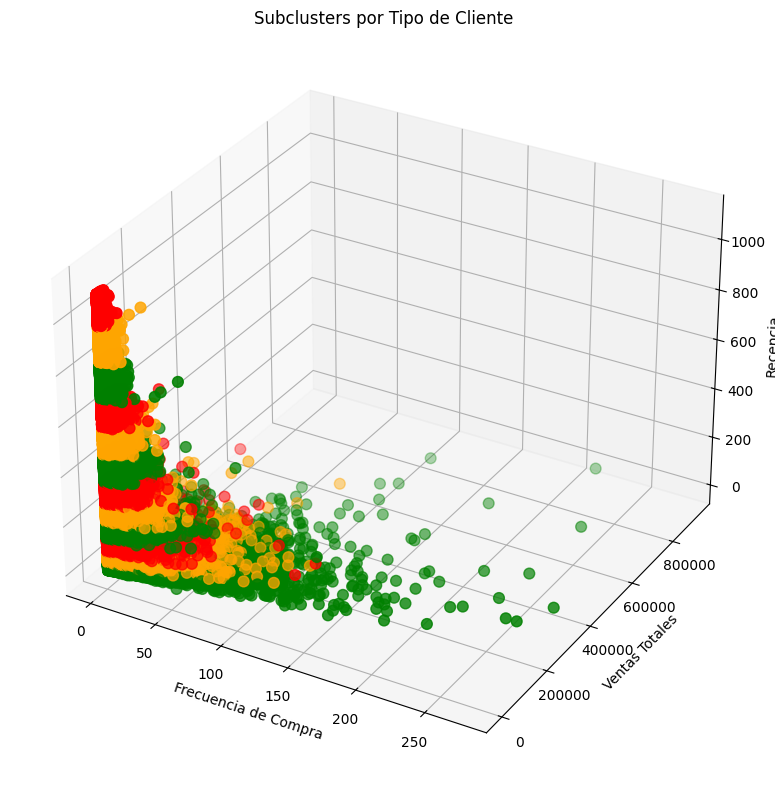

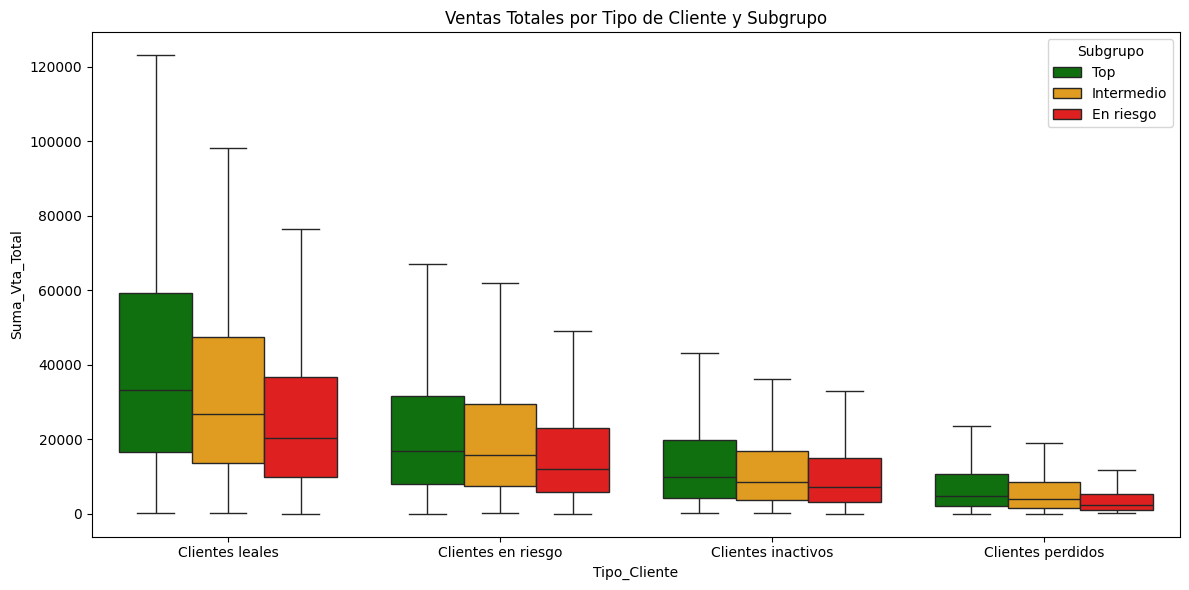

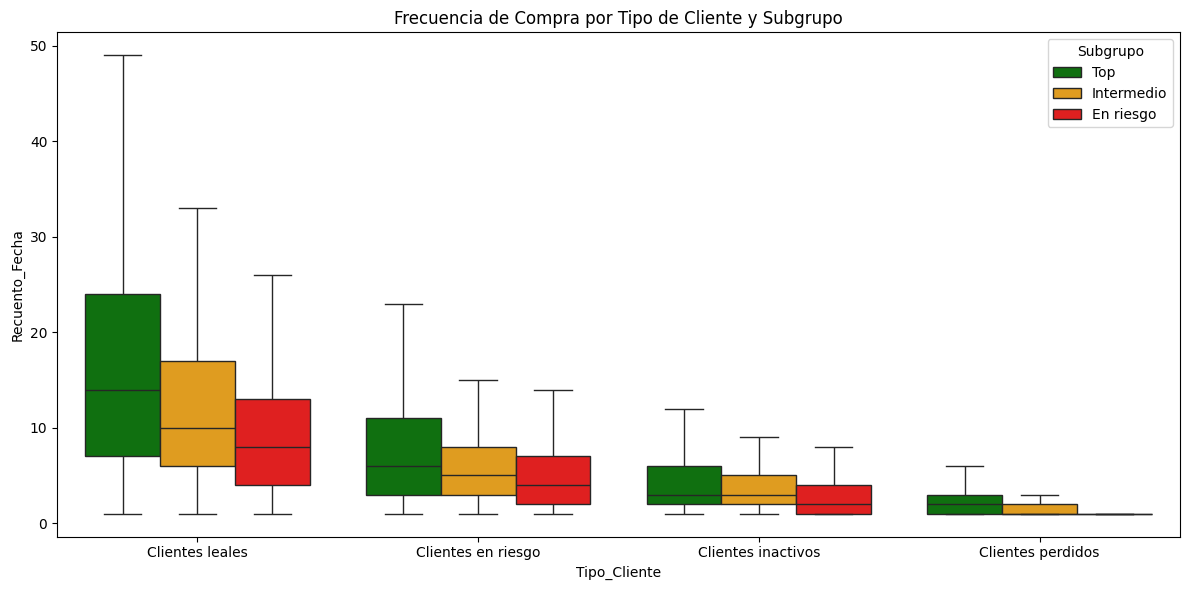

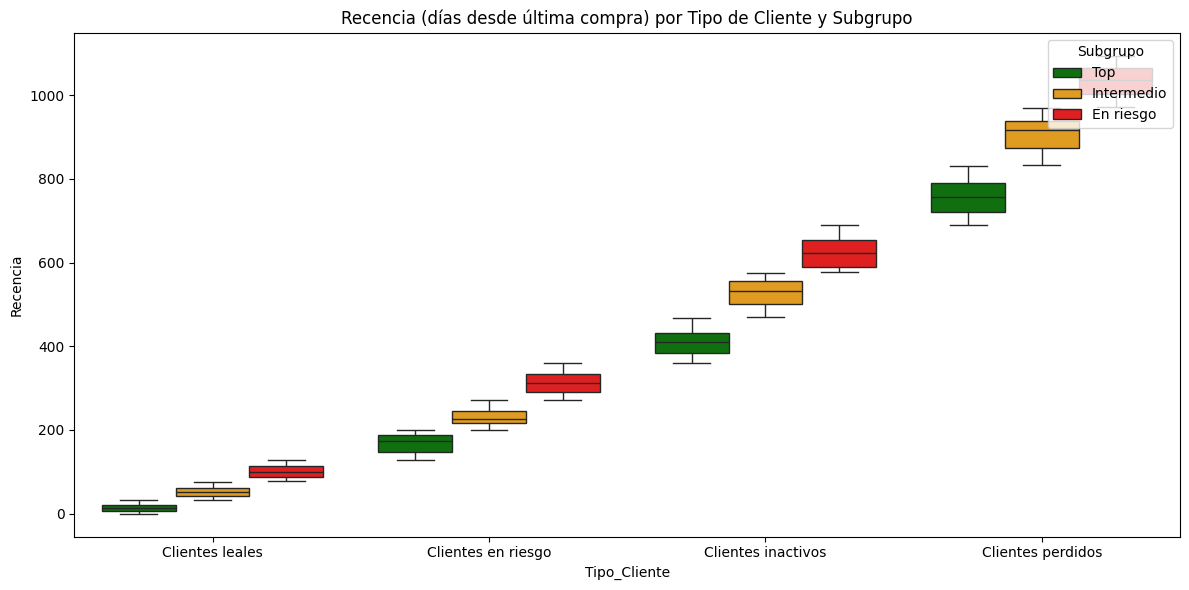

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\356941233.py:91: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv")


In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Cargar datos desde CSV con Tipo_Cliente ya asignado
df = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv")
df = df[['CUENTA','Recuento de Fecha', 'Suma de Vta Total', 'Última fecha: Fecha', 'Tipo_Cliente']]

df = df[(df['Suma de Vta Total'] > 0) & 
        (df['Recuento de Fecha'] > 0)]

df.columns = ['CUENTA','Recuento_Fecha', 'Suma_Vta_Total', 'Ultima_Fecha', 'Tipo_Cliente']

# Calcular recencia
df['Ultima_Fecha'] = pd.to_datetime(df['Ultima_Fecha'])
fecha_ref = df['Ultima_Fecha'].max()
df['Recencia'] = (fecha_ref - df['Ultima_Fecha']).dt.days

# Subsegmentar dentro de cada Tipo_Cliente
features = ['Recuento_Fecha', 'Suma_Vta_Total', 'Recencia']
scaler = StandardScaler()
df_final = pd.DataFrame()

# Definir pesos para cada variable (Frecuencia, Ventas, Recencia)
pesos = np.array([0.5, 0.5, 25])  # Ajusta estos valores según tu necesidad

for tipo in df['Tipo_Cliente'].unique():
    sub = df[df['Tipo_Cliente'] == tipo].copy()
    
    # Escalar los datos
    sub_scaled = scaler.fit_transform(sub[features])
    
    # Aplicar pesos
    sub_scaled_weighted = sub_scaled * pesos
    
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    sub['Subgrupo'] = kmeans.fit_predict(sub_scaled_weighted)

    # Calcular e imprimir el Silhouette Score
    score = silhouette_score(sub_scaled_weighted, kmeans.labels_)
    print(f"🔹 Silhouette Score para '{tipo}': {score:.4f}")

    centros = kmeans.cluster_centers_
    orden = np.argsort([c[1] - c[2] for c in centros])  # Puedes ajustar este criterio según los pesos
    etiquetas = {orden[0]: 'En riesgo', orden[1]: 'Intermedio', orden[2]: 'Top'}
    sub['Subgrupo'] = sub['Subgrupo'].map(etiquetas)

    df_final = pd.concat([df_final, sub], ignore_index=True)

# Ordenar subgrupos
orden_subgrupos = ['Top', 'Intermedio', 'En riesgo']
df_final['Subgrupo'] = pd.Categorical(df_final['Subgrupo'], categories=orden_subgrupos, ordered=True)

# Gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = {'Top': 'green', 'Intermedio': 'orange', 'En riesgo': 'red'}

ax.scatter(
    df_final['Recuento_Fecha'],
    df_final['Suma_Vta_Total'],
    df_final['Recencia'],
    c=df_final['Subgrupo'].map(colors), s=60
)
ax.set_xlabel('Frecuencia de Compra')
ax.set_ylabel('Ventas Totales')
ax.set_zlabel('Recencia')
ax.set_title('Subclusters por Tipo de Cliente')
plt.tight_layout()
plt.show()

# Boxplots
variables = ['Suma_Vta_Total', 'Recuento_Fecha', 'Recencia']
titulos = ['Ventas Totales', 'Frecuencia de Compra', 'Recencia (días desde última compra)']

for var, titulo in zip(variables, titulos):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_final, x='Tipo_Cliente', y=var, hue='Subgrupo',
                hue_order=orden_subgrupos,showfliers=False, palette=colors)
    plt.title(f'{titulo} por Tipo de Cliente y Subgrupo')
    plt.legend(title='Subgrupo', loc='upper right')
    plt.tight_layout()
    plt.show()

# Cargar el archivo original
df_original = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv")

# Hacer merge basado solo en la columna Cuenta
df_resultado = df_original.merge(
    df_final[['CUENTA', 'Subgrupo']],
    on='CUENTA',
    how='left'
)
df_resultado = df_resultado.drop_duplicates()
# Guardar resultado
df_resultado.to_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", index=False)

### Comparación de Quintiles de 36 meses y 34 meses y se guarda en Analisis_Cambio_Clientes_36a34meses.csv

In [12]:
import pandas as pd

# Cargar datasets
df_34 = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes34meses.csv", parse_dates=["Última fecha: Fecha"])
df_36 = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", parse_dates=["Última fecha: Fecha"])

# Renombrar columnas para diferenciarlas
df_34 = df_34.rename(columns={
    "Suma de Vta Total": "Venta_34",
    "Recuento de Fecha": "Frecuencia_34",
    "ETIQ1": "Venta_Q34",
    "ETIQ2": "Frecuencia_Q34",
    "ETIQ3": "Frescura_Q34",
    "CUENTA":"Cliente"
})

df_36 = df_36.rename(columns={
    "Suma de Vta Total": "Venta_36",
    "Recuento de Fecha": "Frecuencia_36",
    "ETIQ1": "Venta_Q36",
    "ETIQ2": "Frecuencia_Q36",
    "ETIQ3": "Frescura_Q36",
    "CUENTA":"Cliente"
})

# Merge de ambos períodos (clientes que aparecen en ambos)
df_merge = pd.merge(df_36[['Cliente', 'Venta_36', 'Frecuencia_36', 'Venta_Q36', 'Frecuencia_Q36', 'Frescura_Q36']],
                    df_34[['Cliente', 'Venta_34', 'Frecuencia_34', 'Venta_Q34', 'Frecuencia_Q34', 'Frescura_Q34']],
                    on='Cliente', how='inner')

# Variables de cambio
df_merge['Cambio_Venta'] = df_merge['Venta_34'] - df_merge['Venta_36']  # 34 es posterior a 36
df_merge['Cambio_Frecuencia'] = df_merge['Frecuencia_34'] - df_merge['Frecuencia_36']

# Indicadores de cambio de quintil
df_merge['Cambio_Quintil_Venta'] = df_merge['Venta_Q34'] != df_merge['Venta_Q36']
df_merge['Cambio_Quintil_Frecuencia'] = df_merge['Frecuencia_Q34'] != df_merge['Frecuencia_Q36']
df_merge['Cambio_Quintil_Frescura'] = df_merge['Frescura_Q34'] != df_merge['Frescura_Q36']

# Dirección del cambio (de 36 → 34 meses)
df_merge['Direccion_Cambio_Venta'] = df_merge.apply(
    lambda x: 'Subió' if x['Venta_Q34'] > x['Venta_Q36'] else ('Bajó' if x['Venta_Q34'] < x['Venta_Q36'] else 'Igual'),
    axis=1
)

df_merge['Direccion_Cambio_Frecuencia'] = df_merge.apply(
    lambda x: 'Subió' if x['Frecuencia_Q34'] > x['Frecuencia_Q36'] else ('Bajó' if x['Frecuencia_Q34'] < x['Frecuencia_Q36'] else 'Igual'),
    axis=1
)

df_merge['Direccion_Cambio_Frescura'] = df_merge.apply(
    lambda x: 'Subió' if x['Frescura_Q34'] > x['Frescura_Q36'] else ('Bajó' if x['Frescura_Q34'] < x['Frescura_Q36'] else 'Igual'),
    axis=1
)

# Ver resultados principales
print(df_merge[['Cliente', 'Venta_36', 'Venta_34', 'Cambio_Venta',
                'Venta_Q36', 'Venta_Q34', 'Direccion_Cambio_Venta']].head())

# Guardar resultados
df_merge.to_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\Analisis_Cambio_Clientes_36a34meses.csv", index=False, encoding='utf-8-sig')


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\536001950.py:4: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_34 = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes34meses.csv", parse_dates=["Última fecha: Fecha"])
C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\536001950.py:5: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_36 = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", parse_dates=["Última fecha: Fecha"])


   Cliente  Venta_36  Venta_34  Cambio_Venta Venta_Q36 Venta_Q34  \
0   345133         0         0             0        V0        V0   
1   183204         0         0             0        V0        V0   
2   381893         0         0             0        V0        V0   
3   378856         0         0             0        V0        V0   
4   293829         0         0             0        V0        V0   

  Direccion_Cambio_Venta  
0                  Igual  
1                  Igual  
2                  Igual  
3                  Igual  
4                  Igual  


### Se agregan las etiquetas de transición al archivo original QuintilesClientes2año.csv

In [13]:
import pandas as pd

# === Cargar los datos ya procesados ===
df_merge = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\Analisis_Cambio_Clientes_36a34meses.csv", encoding='utf-8-sig')



# Crear columna de transición tipo "V3->V4"
df_merge['TransicionV (36->34)'] = df_merge['Venta_Q36'].astype(str) + ' -> ' + df_merge['Venta_Q34'].astype(str)
df_merge['TransicionF (36->34)'] = df_merge['Frecuencia_Q36'].astype(str) + ' -> ' + df_merge['Frecuencia_Q34'].astype(str)
df_merge['TransicionR (36->34)'] = df_merge['Frescura_Q36'].astype(str) + ' -> ' + df_merge['Frescura_Q34'].astype(str)

# === Cargar el archivo base de 36 meses ===
df_36 = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", encoding='utf-8-sig')

if 'TransicionV (36->34)' in df_36.columns:
    df_36 = df_36.drop(columns=['TransicionV (36->34)'])
if 'TransicionF (36->34)' in df_36.columns:
    df_36 = df_36.drop(columns=['TransicionF (36->34)'])
if 'TransicionR (36->34)' in df_36.columns:
    df_36 = df_36.drop(columns=['TransicionR (36->34)'])


# Renombrar columna CUENTA si no está así
if 'CUENTA' not in df_36.columns:
    df_36 = df_36.rename(columns={'Cliente': 'CUENTA'})

# Unir la columna de transición con base en CUENTA
df_36 = pd.merge(df_36, df_merge[['Cliente', 'TransicionV (36->34)','TransicionF (36->34)','TransicionR (36->34)']], left_on='CUENTA', right_on='Cliente', how='left')
df_36.drop(columns='Cliente', inplace=True)

# === Guardar el nuevo archivo con la columna Transición ===
output_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
df_36.drop_duplicates(inplace=True)  # Eliminar duplicados si los hubiera

df_36.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ Columna 'Transicion' añadida y archivo guardado en:\n{output_path}")


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\103948.py:14: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_36 = pd.read_csv(r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv", encoding='utf-8-sig')


✅ Columna 'Transicion' añadida y archivo guardado en:
C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv


## Matrices de Transición

### Valor

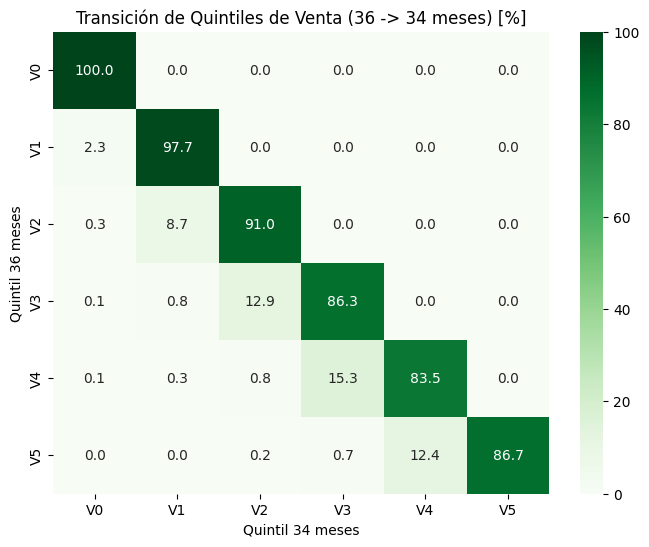

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear tabla de transición en valores absolutos
transicion = df_merge.groupby(['Venta_Q36', 'Venta_Q34']).size().unstack(fill_value=0)

# Normalizar por fila (porcentaje de transición desde cada quintil original)
transicion_pct = transicion.div(transicion.sum(axis=1), axis=0) * 100  # convierte a porcentaje

# Graficar heatmap en porcentaje
plt.figure(figsize=(8,6))
sns.heatmap(transicion_pct, annot=True, fmt='.1f', cmap="Greens")

plt.title('Transición de Quintiles de Venta (36 -> 34 meses) [%]')
plt.xlabel('Quintil 34 meses')
plt.ylabel('Quintil 36 meses')
plt.show()



### Frecuencia


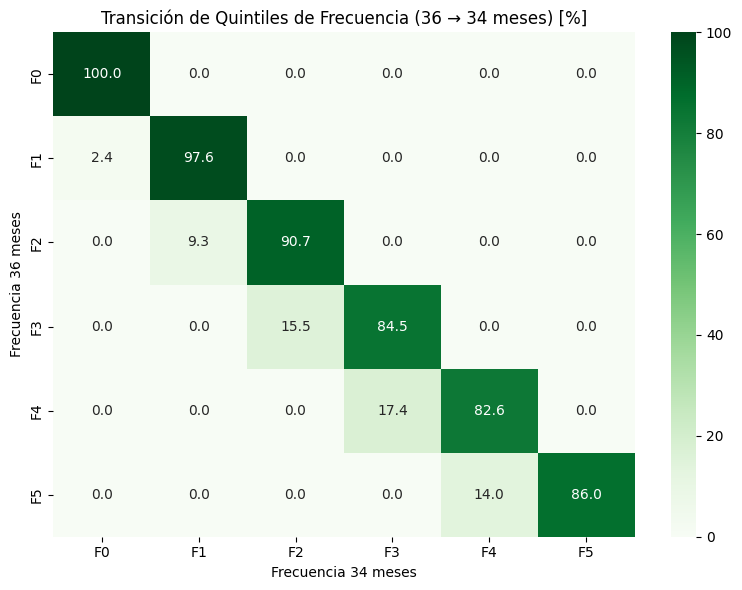

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de transición en valores absolutos
frecuencia_transicion = pd.crosstab(df_merge['Frecuencia_Q36'], df_merge['Frecuencia_Q34'])

# Normalizar por fila (porcentajes)
frecuencia_transicion_pct = frecuencia_transicion.div(frecuencia_transicion.sum(axis=1), axis=0) * 100

# Graficar heatmap en porcentaje
plt.figure(figsize=(8, 6))
sns.heatmap(frecuencia_transicion_pct, annot=True, fmt='.1f', cmap="Greens")

plt.title("Transición de Quintiles de Frecuencia (36 → 34 meses) [%]")
plt.xlabel("Frecuencia 34 meses")
plt.ylabel("Frecuencia 36 meses")
plt.tight_layout()
plt.show()



### Frescura

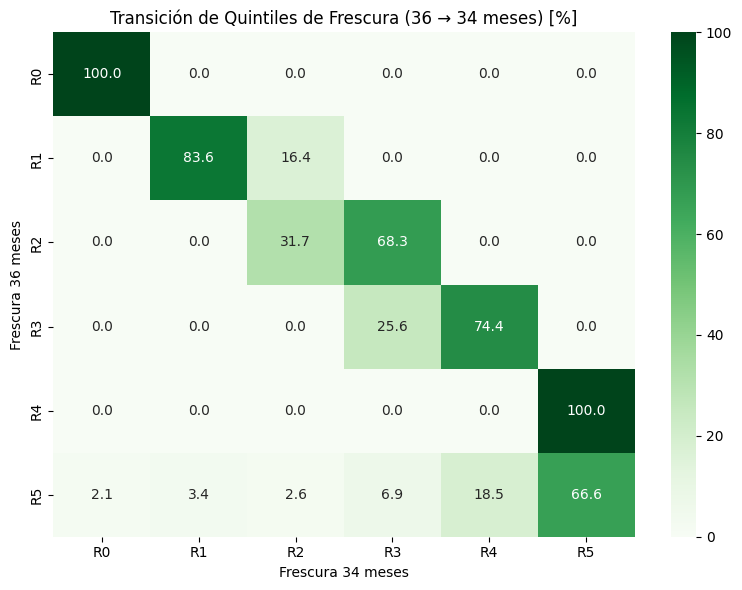

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de transición en valores absolutos
frescura_transicion = pd.crosstab(df_merge['Frescura_Q36'], df_merge['Frescura_Q34'])

# Normalizar por fila (porcentajes)
frescura_transicion_pct = frescura_transicion.div(frescura_transicion.sum(axis=1), axis=0) * 100

# Heatmap con porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(frescura_transicion_pct, annot=True, fmt='.1f', cmap="Greens")

plt.title("Transición de Quintiles de Frescura (36 → 34 meses) [%]")
plt.xlabel("Frescura 34 meses")
plt.ylabel("Frescura 36 meses")
plt.tight_layout()
plt.show()



### Analisis de Sensibilidad para cada Segmento (Modificar Quintiles en Caso de Cambio)

C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_80684\2681296501.py:54: DtypeWarning: Columns (13,14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path, encoding='utf-8-sig')


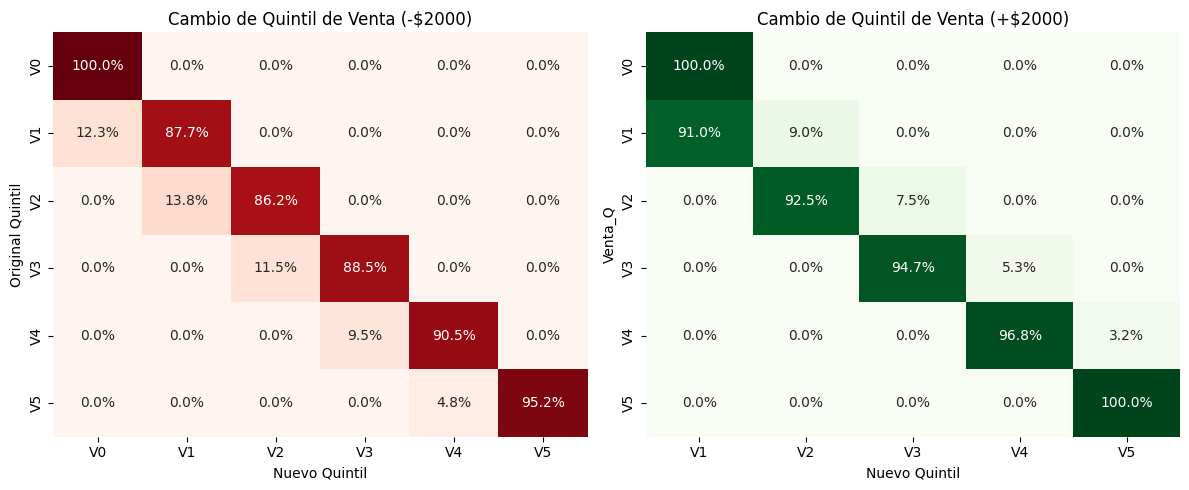

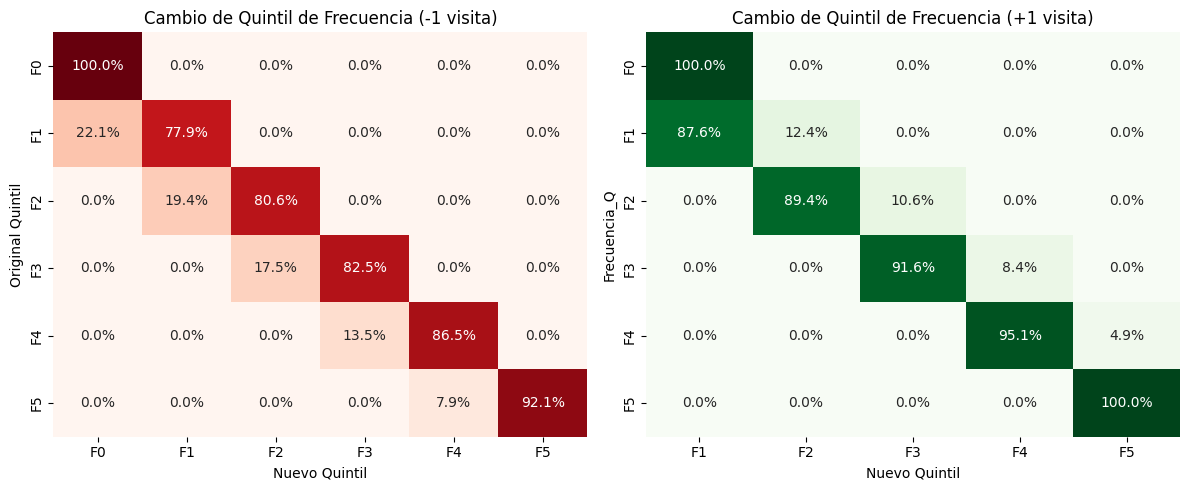

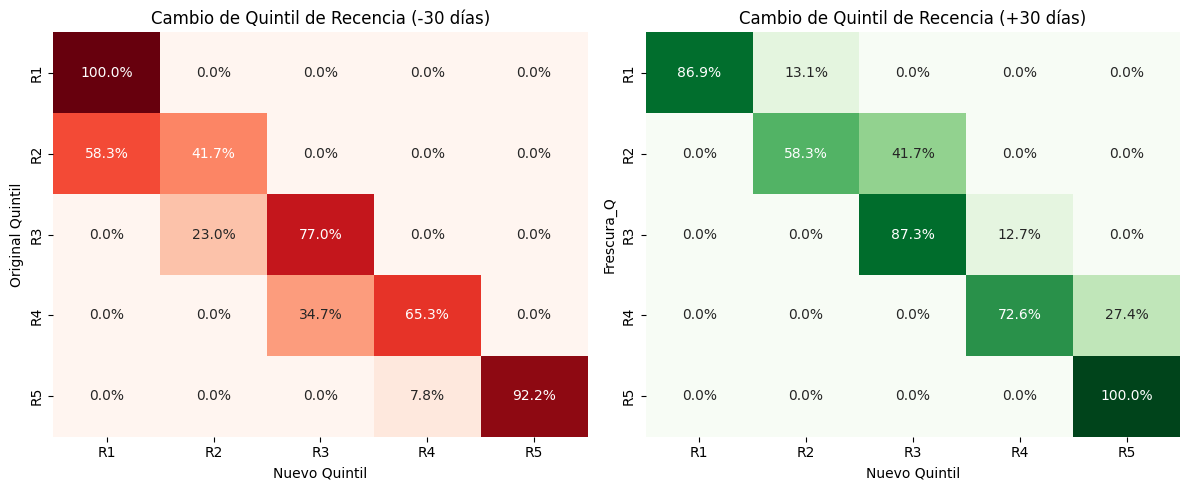

✅ Archivo actualizado con columnas de simulación (formato transición): C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv
Columnas añadidas: ['Venta_+2000', 'Venta_-2000', 'Frecuencia_+1', 'Frecuencia_-1', 'Frescura_+30d', 'Frescura_-30d']


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# ---------------------------
# FUNCIONES DE CLASIFICACIÓN
# ---------------------------

def clasificar_venta(monto):
    if monto >= 96001:
        return 'V5'
    elif monto >= 61001:
        return 'V4'
    elif monto >= 36001:
        return 'V3'
    elif monto >= 17001:
        return 'V2'
    elif monto >= 1:
        return 'V1'
    else:
        return 'V0'

def clasificar_frecuencia(freq):
    if freq >= 34:
        return 'F5'
    elif freq >= 22:
        return 'F4'
    elif freq >= 14:
        return 'F3'
    elif freq >= 7:
        return 'F2'
    elif freq >= 1:
        return 'F1'
    else:
        return 'F0'

def clasificar_frescura(dias):
    if dias >= 366:
        return 'R5'
    elif dias >= 271:
        return 'R4'
    elif dias >= 151:
        return 'R3'
    elif dias >= 91:
        return 'R2'
    elif dias >= 0:
        return 'R1'
    else:
        return 'R0'

# --- Cargar el archivo base ---
input_path = r"C:\Users\jose.valdez\Desktop\python\jose luis\Quintiles\La Marina\Cuatro Clusters\QuintilesClientes2año.csv"
df = pd.read_csv(input_path, encoding='utf-8-sig')

# Convert relevant columns to numeric, coercing errors to NaN
df['Suma de Vta Total'] = pd.to_numeric(df['Suma de Vta Total'], errors='coerce')
df['Recuento de Fecha'] = pd.to_numeric(df['Recuento de Fecha'], errors='coerce')

# Fecha de corte para cálculos
fecha_corte = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce').max()

# ---------------------------
# PREPARACIÓN DE DATOS
# ---------------------------

# Calcular frescura en días (desde última compra hasta fecha corte)
df['Última fecha: Fecha'] = pd.to_datetime(df['Última fecha: Fecha'], errors='coerce')
df['Frescura_dias'] = (fecha_corte - df['Última fecha: Fecha']).dt.days
df['Frescura_dias'] = df['Frescura_dias'].fillna(0).astype(int)

# Clasificaciones originales
df['Venta_Q'] = df['Suma de Vta Total'].apply(clasificar_venta)
df['Frecuencia_Q'] = df['Recuento de Fecha'].apply(clasificar_frecuencia)
df['Frescura_Q'] = df['Frescura_dias'].apply(clasificar_frescura)

# ---------------------------------------------
# SIMULACIÓN PARA VENTA: +/- 2000 pesos
# ---------------------------------------------
df['Venta_menos'] = df['Suma de Vta Total'] - 2000
df['Venta_mas'] = df['Suma de Vta Total'] + 2000

df['Venta_Q_menos'] = df['Venta_menos'].apply(clasificar_venta)
df['Venta_Q_mas'] = df['Venta_mas'].apply(clasificar_venta)

# Heatmaps para venta
venta_menos = pd.crosstab(df['Venta_Q'], df['Venta_Q_menos'], normalize='index')
venta_mas = pd.crosstab(df['Venta_Q'], df['Venta_Q_mas'], normalize='index')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(venta_menos, annot=True, cmap="Reds", fmt=".1%", cbar=False)
plt.title('Cambio de Quintil de Venta (-$2000)')
plt.xlabel('Nuevo Quintil')
plt.ylabel('Original Quintil')

plt.subplot(1, 2, 2)
sns.heatmap(venta_mas, annot=True, cmap="Greens", fmt=".1%", cbar=False)
plt.title('Cambio de Quintil de Venta (+$2000)')
plt.xlabel('Nuevo Quintil')
plt.tight_layout()
plt.show()

# ---------------------------------------------
# SIMULACIÓN PARA FRECUENCIA: +/- 1 visita
# ---------------------------------------------
df['Frecuencia_menos'] = df['Recuento de Fecha'] - 1
df['Frecuencia_mas'] = df['Recuento de Fecha'] + 1

df['Frecuencia_Q_menos'] = df['Frecuencia_menos'].apply(clasificar_frecuencia)
df['Frecuencia_Q_mas'] = df['Frecuencia_mas'].apply(clasificar_frecuencia)

# Heatmaps para frecuencia
freq_menos = pd.crosstab(df['Frecuencia_Q'], df['Frecuencia_Q_menos'], normalize='index')
freq_mas = pd.crosstab(df['Frecuencia_Q'], df['Frecuencia_Q_mas'], normalize='index')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(freq_menos, annot=True, cmap="Reds", fmt=".1%", cbar=False)
plt.title('Cambio de Quintil de Frecuencia (-1 visita)')
plt.xlabel('Nuevo Quintil')
plt.ylabel('Original Quintil')

plt.subplot(1, 2, 2)
sns.heatmap(freq_mas, annot=True, cmap="Greens", fmt=".1%", cbar=False)
plt.title('Cambio de Quintil de Frecuencia (+1 visita)')
plt.xlabel('Nuevo Quintil')
plt.tight_layout()
plt.show()

# ---------------------------------------------
# SIMULACIÓN PARA FRESCURA: +/- 30 días
# ---------------------------------------------
df['Frescura_menos'] = df['Frescura_dias'] - 30
df['Frescura_mas'] = df['Frescura_dias'] + 30

# Asegurar que no hay valores negativos
df['Frescura_menos'] = df['Frescura_menos'].clip(lower=0)
df['Frescura_mas'] = df['Frescura_mas'].clip(lower=0)

df['Frescura_Q_menos'] = df['Frescura_menos'].apply(clasificar_frescura)
df['Frescura_Q_mas'] = df['Frescura_mas'].apply(clasificar_frescura)

# Heatmaps para frescura
frescura_menos = pd.crosstab(df['Frescura_Q'], df['Frescura_Q_menos'], normalize='index')
frescura_mas = pd.crosstab(df['Frescura_Q'], df['Frescura_Q_mas'], normalize='index')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(frescura_menos, annot=True, cmap="Reds", fmt=".1%", cbar=False)
plt.title('Cambio de Quintil de Recencia (-30 días)')
plt.xlabel('Nuevo Quintil')
plt.ylabel('Original Quintil')

plt.subplot(1, 2, 2)
sns.heatmap(frescura_mas, annot=True, cmap="Greens", fmt=".1%", cbar=False)
plt.title('Cambio de Quintil de Recencia (+30 días)')
plt.xlabel('Nuevo Quintil')
plt.tight_layout()
plt.show()

if 'Venta_+2000' in df.columns:
    df = df.drop(columns=['Venta_+2000'])
if 'Venta_-2000' in df.columns:
    df = df.drop(columns=['Venta_-2000'])
if 'Frecuencia_+1' in df.columns:
    df = df.drop(columns=['Frecuencia_+1'])
if 'Frecuencia_-1' in df.columns:
    df = df.drop(columns=['Frecuencia_-1'])
if 'Frescura_+30d' in df.columns:
    df = df.drop(columns=['Frescura_+30d'])
if 'Frescura_-30d' in df.columns:
    df = df.drop(columns=['Frescura_-30d'])


# --- Añadir columnas de transición al archivo original ---
df['Venta_+2000'] = df['Venta_Q'] + ' -> ' + df['Venta_Q_mas']
df['Venta_-2000'] = df['Venta_Q'] + ' -> ' + df['Venta_Q_menos']
df['Frecuencia_+1'] = df['Frecuencia_Q'] + ' -> ' + df['Frecuencia_Q_mas']
df['Frecuencia_-1'] = df['Frecuencia_Q'] + ' -> ' + df['Frecuencia_Q_menos']
df['Frescura_+30d'] = df['Frescura_Q'] + ' -> ' + df['Frescura_Q_mas']
df['Frescura_-30d'] = df['Frescura_Q'] + ' -> ' + df['Frescura_Q_menos']

df = df.drop(columns=['Venta_menos', 'Venta_mas', 'Frecuencia_menos', 'Frecuencia_mas', 'Frescura_menos', 'Frescura_mas','Frecuencia_Q_menos', 'Frescura_Q_mas'])
df = df.drop(columns=['Venta_Q_menos', 'Venta_Q_mas', 'Frescura_Q_menos', 'Venta_Q','Frecuencia_Q','Frescura_Q','Frecuencia_Q_mas'])
df.drop_duplicates(inplace=True)
# --- Guardar el archivo actualizado ---
df.to_csv(input_path, index=False, encoding='utf-8-sig')

print("✅ Archivo actualizado con columnas de simulación (formato transición):", input_path)
print("Columnas añadidas:", list(df.columns[-6:]))  # Muestra las 6 nuevas columnas